In [5]:
import random
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------- Paths ----------- 
GEN_INPUT_PATH = r"C:\Users\cl502_11\MG\Feature Extraction\GANs Inputs\Generator\MW_latent.npy"
DISC_REAL_DIR = r"C:\Users\cl502_11\MG\Feature Extraction\GANs Inputs\Discriminator"
SAVE_DIR = r"C:\Users\cl502_11\MG\Models\melgans"
os.makedirs(SAVE_DIR, exist_ok=True)

# ----------- Load Latents ----------- 
latent_vectors = np.load(GEN_INPUT_PATH)
if latent_vectors.ndim == 1:
    latent_vectors = latent_vectors.reshape(1, -1)
print("Latent shape:", latent_vectors.shape)

# ----------- Load Real Data ----------- 
real_data = []
for file in os.listdir(DISC_REAL_DIR):
    if file.endswith(".npy"):
        path = os.path.join(DISC_REAL_DIR, file)
        arr = np.load(path)
        real_data.append(arr)

real_data = np.array(real_data)
print("Real data shape:", real_data.shape)

# ----------- Dataset ----------- 
class AudioDataset(Dataset):
    def __init__(self, latents, reals):
        self.latents = latents
        self.reals = reals

    def __len__(self):
        return min(len(self.latents), len(self.reals))

    def __getitem__(self, idx):
        latent = self.latents[idx]
        real = self.reals[idx]
        return torch.tensor(latent, dtype=torch.float32), torch.tensor(real, dtype=torch.float32)

# ----------- Models ----------- 
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# ----------- Hyperparameter Search Space ----------- 
learning_rates = [0.0001, 0.0002, 0.0005]
batch_sizes = [16, 32, 64]
hidden_dims = [512, 1024, 2048]
epochs_list = [50, 70, 100]

# ----------- Random Search ----------- 
best_loss = float('inf')
best_params = {}

# ----------- Random Search Loop ----------- 
for _ in range(10):  # Number of random search trials
    # Randomly select hyperparameters
    lr = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    hidden_dim = random.choice(hidden_dims)
    epochs = random.choice(epochs_list)

    print(f"Trial with LR={lr}, Batch Size={batch_size}, Hidden Dim={hidden_dim}, Epochs={epochs}")

    # ----------- Prepare Models ----------- 
    latent_dim = latent_vectors.shape[1]
    audio_length = real_data.shape[1]

    generator = Generator(input_dim=latent_dim, output_dim=audio_length, hidden_dim=hidden_dim)
    discriminator = Discriminator(input_dim=audio_length, hidden_dim=hidden_dim)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    # ----------- DataLoader Setup ----------- 
    dataset = AudioDataset(latent_vectors, real_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=lr)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

    # ----------- Tracking Losses ----------- 
    d_losses = []  # List to track Discriminator loss
    g_losses = []  # List to track Generator loss

    # ----------- Training Loop ----------- 
    for epoch in range(epochs):
        for latent, real in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):

            latent, real = latent.to(device), real.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            fake = generator(latent).detach()
            real_preds = discriminator(real)
            fake_preds = discriminator(fake)

            real_loss = criterion(real_preds, torch.ones_like(real_preds))
            fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            generated = generator(latent)
            preds = discriminator(generated)
            g_loss = criterion(preds, torch.ones_like(preds))
            g_loss.backward()
            optimizer_G.step()

        # Store losses for plotting
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Evaluate and store the best configuration
    final_loss = g_losses[-1]  # We use generator loss as an indicator for best model
    if final_loss < best_loss:
        best_loss = final_loss
        best_params = {
            'learning_rate': lr,
            'batch_size': batch_size,
            'hidden_dim': hidden_dim,
            'epochs': epochs
        }

# ----------- Print Best Hyperparameters ----------- 
print("\nBest Hyperparameters Found:")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Hidden Dimension: {best_params['hidden_dim']}")
print(f"Epochs: {best_params['epochs']}")
print(f"Best Generator Loss: {best_loss:.4f}")


Latent shape: (1, 1024)
Real data shape: (767, 1024)
Trial with LR=0.0002, Batch Size=32, Hidden Dim=512, Epochs=50


Epoch 1/50: 100%|██████████| 1/1 [00:00<00:00, 30.01it/s]


Epoch [1/50] | D Loss: 26.9125 | G Loss: 1.0371


Epoch 2/50: 100%|██████████| 1/1 [00:00<00:00, 55.53it/s]


Epoch [2/50] | D Loss: 32.1988 | G Loss: 1.2425


Epoch 3/50: 100%|██████████| 1/1 [00:00<00:00, 27.48it/s]


Epoch [3/50] | D Loss: 41.0003 | G Loss: 1.5060


Epoch 4/50: 100%|██████████| 1/1 [00:00<00:00, 36.89it/s]


Epoch [4/50] | D Loss: 50.1406 | G Loss: 1.8695


Epoch 5/50: 100%|██████████| 1/1 [00:00<00:00, 40.46it/s]


Epoch [5/50] | D Loss: 50.0939 | G Loss: 2.2841


Epoch 6/50: 100%|██████████| 1/1 [00:00<00:00, 39.48it/s]


Epoch [6/50] | D Loss: 50.0670 | G Loss: 2.6415


Epoch 7/50: 100%|██████████| 1/1 [00:00<00:00, 36.13it/s]


Epoch [7/50] | D Loss: 50.0424 | G Loss: 3.1007


Epoch 8/50: 100%|██████████| 1/1 [00:00<00:00, 40.07it/s]


Epoch [8/50] | D Loss: 50.0269 | G Loss: 3.5507


Epoch 9/50: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]


Epoch [9/50] | D Loss: 50.0165 | G Loss: 4.0338


Epoch 10/50: 100%|██████████| 1/1 [00:00<00:00, 37.00it/s]


Epoch [10/50] | D Loss: 50.0101 | G Loss: 4.5053


Epoch 11/50: 100%|██████████| 1/1 [00:00<00:00, 36.28it/s]


Epoch [11/50] | D Loss: 50.0062 | G Loss: 4.9687


Epoch 12/50: 100%|██████████| 1/1 [00:00<00:00, 32.02it/s]


Epoch [12/50] | D Loss: 50.0044 | G Loss: 5.2831


Epoch 13/50: 100%|██████████| 1/1 [00:00<00:00, 42.17it/s]


Epoch [13/50] | D Loss: 50.0030 | G Loss: 5.6296


Epoch 14/50: 100%|██████████| 1/1 [00:00<00:00, 40.78it/s]


Epoch [14/50] | D Loss: 50.0021 | G Loss: 5.9506


Epoch 15/50: 100%|██████████| 1/1 [00:00<00:00, 37.55it/s]


Epoch [15/50] | D Loss: 50.0015 | G Loss: 6.2341


Epoch 16/50: 100%|██████████| 1/1 [00:00<00:00, 36.66it/s]


Epoch [16/50] | D Loss: 50.0011 | G Loss: 6.5068


Epoch 17/50: 100%|██████████| 1/1 [00:00<00:00, 37.86it/s]


Epoch [17/50] | D Loss: 50.0010 | G Loss: 6.6426


Epoch 18/50: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]


Epoch [18/50] | D Loss: 50.0008 | G Loss: 6.7934


Epoch 19/50: 100%|██████████| 1/1 [00:00<00:00, 41.93it/s]


Epoch [19/50] | D Loss: 50.0007 | G Loss: 6.9560


Epoch 20/50: 100%|██████████| 1/1 [00:00<00:00, 42.93it/s]


Epoch [20/50] | D Loss: 50.0005 | G Loss: 7.1677


Epoch 21/50: 100%|██████████| 1/1 [00:00<00:00, 34.01it/s]


Epoch [21/50] | D Loss: 50.0004 | G Loss: 7.3657


Epoch 22/50: 100%|██████████| 1/1 [00:00<00:00, 36.44it/s]


Epoch [22/50] | D Loss: 50.0003 | G Loss: 7.6293


Epoch 23/50: 100%|██████████| 1/1 [00:00<00:00, 33.28it/s]


Epoch [23/50] | D Loss: 50.0003 | G Loss: 7.7562


Epoch 24/50: 100%|██████████| 1/1 [00:00<00:00, 41.43it/s]


Epoch [24/50] | D Loss: 50.0003 | G Loss: 7.7804


Epoch 25/50: 100%|██████████| 1/1 [00:00<00:00, 40.03it/s]


Epoch [25/50] | D Loss: 50.0002 | G Loss: 7.9432


Epoch 26/50: 100%|██████████| 1/1 [00:00<00:00, 41.04it/s]


Epoch [26/50] | D Loss: 50.0002 | G Loss: 8.0823


Epoch 27/50: 100%|██████████| 1/1 [00:00<00:00, 40.92it/s]


Epoch [27/50] | D Loss: 50.0002 | G Loss: 8.2603


Epoch 28/50: 100%|██████████| 1/1 [00:00<00:00, 38.38it/s]

Epoch [28/50] | D Loss: 50.0001 | G Loss: 8.4029



Epoch 29/50: 100%|██████████| 1/1 [00:00<00:00, 38.15it/s]


Epoch [29/50] | D Loss: 50.0001 | G Loss: 8.4904


Epoch 30/50: 100%|██████████| 1/1 [00:00<00:00, 42.30it/s]


Epoch [30/50] | D Loss: 50.0001 | G Loss: 8.6308


Epoch 31/50: 100%|██████████| 1/1 [00:00<00:00, 36.50it/s]


Epoch [31/50] | D Loss: 50.0001 | G Loss: 8.7207


Epoch 32/50: 100%|██████████| 1/1 [00:00<00:00, 34.39it/s]


Epoch [32/50] | D Loss: 50.0001 | G Loss: 8.8085


Epoch 33/50: 100%|██████████| 1/1 [00:00<00:00, 36.15it/s]


Epoch [33/50] | D Loss: 50.0001 | G Loss: 8.9000


Epoch 34/50: 100%|██████████| 1/1 [00:00<00:00, 40.84it/s]


Epoch [34/50] | D Loss: 50.0001 | G Loss: 8.9559


Epoch 35/50: 100%|██████████| 1/1 [00:00<00:00, 40.29it/s]


Epoch [35/50] | D Loss: 50.0001 | G Loss: 9.0336


Epoch 36/50: 100%|██████████| 1/1 [00:00<00:00, 35.93it/s]


Epoch [36/50] | D Loss: 50.0001 | G Loss: 9.0534


Epoch 37/50: 100%|██████████| 1/1 [00:00<00:00, 35.95it/s]


Epoch [37/50] | D Loss: 50.0001 | G Loss: 9.0775


Epoch 38/50: 100%|██████████| 1/1 [00:00<00:00, 33.96it/s]


Epoch [38/50] | D Loss: 50.0001 | G Loss: 9.0162


Epoch 39/50: 100%|██████████| 1/1 [00:00<00:00, 41.55it/s]


Epoch [39/50] | D Loss: 50.0001 | G Loss: 8.9621


Epoch 40/50: 100%|██████████| 1/1 [00:00<00:00, 37.62it/s]


Epoch [40/50] | D Loss: 50.0001 | G Loss: 9.0233


Epoch 41/50: 100%|██████████| 1/1 [00:00<00:00, 39.46it/s]


Epoch [41/50] | D Loss: 50.0001 | G Loss: 9.0799


Epoch 42/50: 100%|██████████| 1/1 [00:00<00:00, 40.45it/s]


Epoch [42/50] | D Loss: 50.0001 | G Loss: 9.0538


Epoch 43/50: 100%|██████████| 1/1 [00:00<00:00, 36.37it/s]


Epoch [43/50] | D Loss: 50.0001 | G Loss: 9.0632


Epoch 44/50: 100%|██████████| 1/1 [00:00<00:00, 38.15it/s]


Epoch [44/50] | D Loss: 50.0001 | G Loss: 9.1082


Epoch 45/50: 100%|██████████| 1/1 [00:00<00:00, 35.87it/s]


Epoch [45/50] | D Loss: 50.0001 | G Loss: 9.1499


Epoch 46/50: 100%|██████████| 1/1 [00:00<00:00, 29.00it/s]


Epoch [46/50] | D Loss: 50.0001 | G Loss: 9.1888


Epoch 47/50: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]


Epoch [47/50] | D Loss: 50.0000 | G Loss: 9.2249


Epoch 48/50: 100%|██████████| 1/1 [00:00<00:00, 38.42it/s]


Epoch [48/50] | D Loss: 50.0000 | G Loss: 9.2586


Epoch 49/50: 100%|██████████| 1/1 [00:00<00:00, 42.93it/s]

Epoch [49/50] | D Loss: 50.0000 | G Loss: 9.2900

Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 36.79it/s]


Epoch [50/50] | D Loss: 50.0000 | G Loss: 9.3194
Trial with LR=0.0002, Batch Size=32, Hidden Dim=1024, Epochs=70


Epoch 1/70: 100%|██████████| 1/1 [00:00<00:00, 26.31it/s]


Epoch [1/70] | D Loss: 30.1809 | G Loss: 1.2656


Epoch 2/70: 100%|██████████| 1/1 [00:00<00:00, 29.18it/s]


Epoch [2/70] | D Loss: 42.2625 | G Loss: 1.5741


Epoch 3/70: 100%|██████████| 1/1 [00:00<00:00, 31.76it/s]


Epoch [3/70] | D Loss: 50.1395 | G Loss: 2.0857


Epoch 4/70: 100%|██████████| 1/1 [00:00<00:00, 32.37it/s]


Epoch [4/70] | D Loss: 50.0954 | G Loss: 2.4720


Epoch 5/70: 100%|██████████| 1/1 [00:00<00:00, 29.08it/s]


Epoch [5/70] | D Loss: 50.0511 | G Loss: 3.1334


Epoch 6/70: 100%|██████████| 1/1 [00:00<00:00, 28.63it/s]


Epoch [6/70] | D Loss: 50.0285 | G Loss: 3.7333


Epoch 7/70: 100%|██████████| 1/1 [00:00<00:00, 29.38it/s]


Epoch [7/70] | D Loss: 50.0155 | G Loss: 4.3082


Epoch 8/70: 100%|██████████| 1/1 [00:00<00:00, 29.75it/s]


Epoch [8/70] | D Loss: 50.0085 | G Loss: 4.8849


Epoch 9/70: 100%|██████████| 1/1 [00:00<00:00, 32.08it/s]


Epoch [9/70] | D Loss: 50.0049 | G Loss: 5.3873


Epoch 10/70: 100%|██████████| 1/1 [00:00<00:00, 27.74it/s]


Epoch [10/70] | D Loss: 50.0028 | G Loss: 5.9133


Epoch 11/70: 100%|██████████| 1/1 [00:00<00:00, 28.82it/s]


Epoch [11/70] | D Loss: 50.0017 | G Loss: 6.3683


Epoch 12/70: 100%|██████████| 1/1 [00:00<00:00, 32.19it/s]


Epoch [12/70] | D Loss: 50.0011 | G Loss: 6.7156


Epoch 13/70: 100%|██████████| 1/1 [00:00<00:00, 30.09it/s]


Epoch [13/70] | D Loss: 50.0010 | G Loss: 6.8071


Epoch 14/70: 100%|██████████| 1/1 [00:00<00:00, 31.75it/s]


Epoch [14/70] | D Loss: 50.0007 | G Loss: 7.0443


Epoch 15/70: 100%|██████████| 1/1 [00:00<00:00, 31.04it/s]


Epoch [15/70] | D Loss: 50.0007 | G Loss: 7.0957


Epoch 16/70: 100%|██████████| 1/1 [00:00<00:00, 30.54it/s]


Epoch [16/70] | D Loss: 50.0005 | G Loss: 7.3231


Epoch 17/70: 100%|██████████| 1/1 [00:00<00:00, 32.58it/s]


Epoch [17/70] | D Loss: 50.0004 | G Loss: 7.5430


Epoch 18/70: 100%|██████████| 1/1 [00:00<00:00, 30.05it/s]


Epoch [18/70] | D Loss: 50.0003 | G Loss: 7.7389


Epoch 19/70: 100%|██████████| 1/1 [00:00<00:00, 25.56it/s]


Epoch [19/70] | D Loss: 50.0003 | G Loss: 7.7142


Epoch 20/70: 100%|██████████| 1/1 [00:00<00:00, 32.01it/s]


Epoch [20/70] | D Loss: 50.0003 | G Loss: 7.8622


Epoch 21/70: 100%|██████████| 1/1 [00:00<00:00, 30.66it/s]


Epoch [21/70] | D Loss: 50.0003 | G Loss: 7.6321


Epoch 22/70: 100%|██████████| 1/1 [00:00<00:00, 22.42it/s]


Epoch [22/70] | D Loss: 50.0003 | G Loss: 7.6154


Epoch 23/70: 100%|██████████| 1/1 [00:00<00:00, 27.75it/s]


Epoch [23/70] | D Loss: 50.0003 | G Loss: 7.7026


Epoch 24/70: 100%|██████████| 1/1 [00:00<00:00, 31.08it/s]


Epoch [24/70] | D Loss: 50.0003 | G Loss: 7.6338


Epoch 25/70: 100%|██████████| 1/1 [00:00<00:00, 30.49it/s]


Epoch [25/70] | D Loss: 50.0003 | G Loss: 7.6993


Epoch 26/70: 100%|██████████| 1/1 [00:00<00:00, 28.85it/s]


Epoch [26/70] | D Loss: 50.0003 | G Loss: 7.7143


Epoch 27/70: 100%|██████████| 1/1 [00:00<00:00, 31.53it/s]


Epoch [27/70] | D Loss: 50.0002 | G Loss: 7.7796


Epoch 28/70: 100%|██████████| 1/1 [00:00<00:00, 30.40it/s]


Epoch [28/70] | D Loss: 50.0002 | G Loss: 7.8898


Epoch 29/70: 100%|██████████| 1/1 [00:00<00:00, 31.12it/s]


Epoch [29/70] | D Loss: 50.0002 | G Loss: 7.8447


Epoch 30/70: 100%|██████████| 1/1 [00:00<00:00, 29.15it/s]


Epoch [30/70] | D Loss: 50.0002 | G Loss: 7.9133


Epoch 31/70: 100%|██████████| 1/1 [00:00<00:00, 31.85it/s]


Epoch [31/70] | D Loss: 50.0002 | G Loss: 7.8783


Epoch 32/70: 100%|██████████| 1/1 [00:00<00:00, 31.16it/s]


Epoch [32/70] | D Loss: 50.0002 | G Loss: 7.9095


Epoch 33/70: 100%|██████████| 1/1 [00:00<00:00, 42.07it/s]


Epoch [33/70] | D Loss: 50.0002 | G Loss: 7.9843


Epoch 34/70: 100%|██████████| 1/1 [00:00<00:00, 30.57it/s]


Epoch [34/70] | D Loss: 50.0002 | G Loss: 7.9562


Epoch 35/70: 100%|██████████| 1/1 [00:00<00:00, 30.34it/s]


Epoch [35/70] | D Loss: 50.0002 | G Loss: 7.9563


Epoch 36/70: 100%|██████████| 1/1 [00:00<00:00, 29.48it/s]


Epoch [36/70] | D Loss: 50.0002 | G Loss: 7.9584


Epoch 37/70: 100%|██████████| 1/1 [00:00<00:00, 32.22it/s]


Epoch [37/70] | D Loss: 50.0002 | G Loss: 7.8542


Epoch 38/70: 100%|██████████| 1/1 [00:00<00:00, 28.43it/s]


Epoch [38/70] | D Loss: 50.0002 | G Loss: 7.9049


Epoch 39/70: 100%|██████████| 1/1 [00:00<00:00, 28.40it/s]


Epoch [39/70] | D Loss: 50.0002 | G Loss: 7.8383


Epoch 40/70: 100%|██████████| 1/1 [00:00<00:00, 31.79it/s]


Epoch [40/70] | D Loss: 50.0002 | G Loss: 7.8679


Epoch 41/70: 100%|██████████| 1/1 [00:00<00:00, 29.63it/s]


Epoch [41/70] | D Loss: 50.0002 | G Loss: 7.9437


Epoch 42/70: 100%|██████████| 1/1 [00:00<00:00, 29.65it/s]


Epoch [42/70] | D Loss: 50.0002 | G Loss: 8.0169


Epoch 43/70: 100%|██████████| 1/1 [00:00<00:00, 28.29it/s]


Epoch [43/70] | D Loss: 50.0002 | G Loss: 8.0876


Epoch 44/70: 100%|██████████| 1/1 [00:00<00:00, 25.72it/s]


Epoch [44/70] | D Loss: 50.0002 | G Loss: 8.1557


Epoch 45/70: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s]


Epoch [45/70] | D Loss: 50.0001 | G Loss: 8.2213


Epoch 46/70: 100%|██████████| 1/1 [00:00<00:00, 29.93it/s]


Epoch [46/70] | D Loss: 50.0002 | G Loss: 8.1535


Epoch 47/70: 100%|██████████| 1/1 [00:00<00:00, 28.71it/s]


Epoch [47/70] | D Loss: 50.0001 | G Loss: 8.2144


Epoch 48/70: 100%|██████████| 1/1 [00:00<00:00, 28.83it/s]


Epoch [48/70] | D Loss: 50.0001 | G Loss: 8.2367


Epoch 49/70: 100%|██████████| 1/1 [00:00<00:00, 29.05it/s]


Epoch [49/70] | D Loss: 50.0001 | G Loss: 8.2936


Epoch 50/70: 100%|██████████| 1/1 [00:00<00:00, 32.47it/s]


Epoch [50/70] | D Loss: 50.0001 | G Loss: 8.2680


Epoch 51/70: 100%|██████████| 1/1 [00:00<00:00, 35.39it/s]


Epoch [51/70] | D Loss: 50.0001 | G Loss: 8.3214


Epoch 52/70: 100%|██████████| 1/1 [00:00<00:00, 31.48it/s]


Epoch [52/70] | D Loss: 50.0001 | G Loss: 8.3732


Epoch 53/70: 100%|██████████| 1/1 [00:00<00:00, 29.59it/s]


Epoch [53/70] | D Loss: 50.0001 | G Loss: 8.4235


Epoch 54/70: 100%|██████████| 1/1 [00:00<00:00, 31.58it/s]


Epoch [54/70] | D Loss: 50.0001 | G Loss: 8.4724


Epoch 55/70: 100%|██████████| 1/1 [00:00<00:00, 29.04it/s]


Epoch [55/70] | D Loss: 50.0001 | G Loss: 8.5196


Epoch 56/70: 100%|██████████| 1/1 [00:00<00:00, 31.33it/s]


Epoch [56/70] | D Loss: 50.0001 | G Loss: 8.5652


Epoch 57/70: 100%|██████████| 1/1 [00:00<00:00, 29.75it/s]


Epoch [57/70] | D Loss: 50.0001 | G Loss: 8.6090


Epoch 58/70: 100%|██████████| 1/1 [00:00<00:00, 29.68it/s]


Epoch [58/70] | D Loss: 50.0001 | G Loss: 8.6514


Epoch 59/70: 100%|██████████| 1/1 [00:00<00:00, 28.03it/s]


Epoch [59/70] | D Loss: 50.0001 | G Loss: 8.6925


Epoch 60/70: 100%|██████████| 1/1 [00:00<00:00, 30.94it/s]


Epoch [60/70] | D Loss: 50.0001 | G Loss: 8.7323


Epoch 61/70: 100%|██████████| 1/1 [00:00<00:00, 27.97it/s]


Epoch [61/70] | D Loss: 50.0001 | G Loss: 8.7215


Epoch 62/70: 100%|██████████| 1/1 [00:00<00:00, 21.95it/s]


Epoch [62/70] | D Loss: 50.0001 | G Loss: 8.6374


Epoch 63/70: 100%|██████████| 1/1 [00:00<00:00, 28.92it/s]


Epoch [63/70] | D Loss: 50.0001 | G Loss: 8.6390


Epoch 64/70: 100%|██████████| 1/1 [00:00<00:00, 27.88it/s]


Epoch [64/70] | D Loss: 50.0001 | G Loss: 8.6410


Epoch 65/70: 100%|██████████| 1/1 [00:00<00:00, 31.47it/s]


Epoch [65/70] | D Loss: 50.0001 | G Loss: 8.6764


Epoch 66/70: 100%|██████████| 1/1 [00:00<00:00, 30.17it/s]


Epoch [66/70] | D Loss: 50.0001 | G Loss: 8.7112


Epoch 67/70: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch [67/70] | D Loss: 50.0001 | G Loss: 8.7453


Epoch 68/70: 100%|██████████| 1/1 [00:00<00:00, 28.55it/s]


Epoch [68/70] | D Loss: 50.0001 | G Loss: 8.7789


Epoch 69/70: 100%|██████████| 1/1 [00:00<00:00, 25.27it/s]


Epoch [69/70] | D Loss: 50.0001 | G Loss: 8.8118


Epoch 70/70: 100%|██████████| 1/1 [00:00<00:00, 29.88it/s]


Epoch [70/70] | D Loss: 50.0001 | G Loss: 8.8440
Trial with LR=0.0002, Batch Size=16, Hidden Dim=512, Epochs=100


Epoch 1/100: 100%|██████████| 1/1 [00:00<00:00, 36.82it/s]


Epoch [1/100] | D Loss: 50.3111 | G Loss: 1.1295


Epoch 2/100: 100%|██████████| 1/1 [00:00<00:00, 40.23it/s]


Epoch [2/100] | D Loss: 50.2596 | G Loss: 1.2497


Epoch 3/100: 100%|██████████| 1/1 [00:00<00:00, 36.29it/s]


Epoch [3/100] | D Loss: 50.1924 | G Loss: 1.5372


Epoch 4/100: 100%|██████████| 1/1 [00:00<00:00, 41.22it/s]


Epoch [4/100] | D Loss: 50.1422 | G Loss: 1.8450


Epoch 5/100: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]


Epoch [5/100] | D Loss: 50.1032 | G Loss: 2.1922


Epoch 6/100: 100%|██████████| 1/1 [00:00<00:00, 39.79it/s]


Epoch [6/100] | D Loss: 50.0689 | G Loss: 2.6081


Epoch 7/100: 100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Epoch [7/100] | D Loss: 50.0446 | G Loss: 3.0458


Epoch 8/100: 100%|██████████| 1/1 [00:00<00:00, 40.60it/s]


Epoch [8/100] | D Loss: 50.0269 | G Loss: 3.5509


Epoch 9/100: 100%|██████████| 1/1 [00:00<00:00, 36.81it/s]


Epoch [9/100] | D Loss: 50.0168 | G Loss: 4.0175


Epoch 10/100: 100%|██████████| 1/1 [00:00<00:00, 39.33it/s]


Epoch [10/100] | D Loss: 50.0107 | G Loss: 4.4482


Epoch 11/100: 100%|██████████| 1/1 [00:00<00:00, 26.71it/s]


Epoch [11/100] | D Loss: 50.0068 | G Loss: 4.8716


Epoch 12/100: 100%|██████████| 1/1 [00:00<00:00, 35.57it/s]


Epoch [12/100] | D Loss: 50.0045 | G Loss: 5.2467


Epoch 13/100: 100%|██████████| 1/1 [00:00<00:00, 39.76it/s]


Epoch [13/100] | D Loss: 50.0031 | G Loss: 5.5977


Epoch 14/100: 100%|██████████| 1/1 [00:00<00:00, 37.47it/s]


Epoch [14/100] | D Loss: 50.0020 | G Loss: 6.0007


Epoch 15/100: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]


Epoch [15/100] | D Loss: 50.0017 | G Loss: 6.1206


Epoch 16/100: 100%|██████████| 1/1 [00:00<00:00, 39.43it/s]


Epoch [16/100] | D Loss: 50.0013 | G Loss: 6.3779


Epoch 17/100: 100%|██████████| 1/1 [00:00<00:00, 40.71it/s]


Epoch [17/100] | D Loss: 50.0011 | G Loss: 6.5301


Epoch 18/100: 100%|██████████| 1/1 [00:00<00:00, 37.49it/s]


Epoch [18/100] | D Loss: 50.0009 | G Loss: 6.7118


Epoch 19/100: 100%|██████████| 1/1 [00:00<00:00, 41.37it/s]


Epoch [19/100] | D Loss: 50.0007 | G Loss: 6.8833


Epoch 20/100: 100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Epoch [20/100] | D Loss: 50.0006 | G Loss: 6.9789


Epoch 21/100: 100%|██████████| 1/1 [00:00<00:00, 40.45it/s]


Epoch [21/100] | D Loss: 50.0006 | G Loss: 7.0614


Epoch 22/100: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


Epoch [22/100] | D Loss: 50.0005 | G Loss: 7.1817


Epoch 23/100: 100%|██████████| 1/1 [00:00<00:00, 40.62it/s]


Epoch [23/100] | D Loss: 50.0004 | G Loss: 7.2630


Epoch 24/100: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]


Epoch [24/100] | D Loss: 50.0004 | G Loss: 7.3619


Epoch 25/100: 100%|██████████| 1/1 [00:00<00:00, 44.41it/s]


Epoch [25/100] | D Loss: 50.0004 | G Loss: 7.4646


Epoch 26/100: 100%|██████████| 1/1 [00:00<00:00, 30.03it/s]


Epoch [26/100] | D Loss: 50.0003 | G Loss: 7.5692


Epoch 27/100: 100%|██████████| 1/1 [00:00<00:00, 35.92it/s]


Epoch [27/100] | D Loss: 50.0003 | G Loss: 7.6278


Epoch 28/100: 100%|██████████| 1/1 [00:00<00:00, 26.08it/s]


Epoch [28/100] | D Loss: 50.0003 | G Loss: 7.6270


Epoch 29/100: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]


Epoch [29/100] | D Loss: 50.0003 | G Loss: 7.7170


Epoch 30/100: 100%|██████████| 1/1 [00:00<00:00, 33.16it/s]


Epoch [30/100] | D Loss: 50.0002 | G Loss: 7.7559


Epoch 31/100: 100%|██████████| 1/1 [00:00<00:00, 43.08it/s]


Epoch [31/100] | D Loss: 50.0002 | G Loss: 7.8174


Epoch 32/100: 100%|██████████| 1/1 [00:00<00:00, 36.59it/s]


Epoch [32/100] | D Loss: 50.0002 | G Loss: 7.7757


Epoch 33/100: 100%|██████████| 1/1 [00:00<00:00, 36.89it/s]


Epoch [33/100] | D Loss: 50.0002 | G Loss: 7.8136


Epoch 34/100: 100%|██████████| 1/1 [00:00<00:00, 35.92it/s]


Epoch [34/100] | D Loss: 50.0002 | G Loss: 7.9192


Epoch 35/100: 100%|██████████| 1/1 [00:00<00:00, 40.89it/s]


Epoch [35/100] | D Loss: 50.0002 | G Loss: 7.9363


Epoch 36/100: 100%|██████████| 1/1 [00:00<00:00, 43.97it/s]


Epoch [36/100] | D Loss: 50.0002 | G Loss: 7.9871


Epoch 37/100: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]


Epoch [37/100] | D Loss: 50.0002 | G Loss: 8.0086


Epoch 38/100: 100%|██████████| 1/1 [00:00<00:00, 27.44it/s]


Epoch [38/100] | D Loss: 50.0002 | G Loss: 8.0894


Epoch 39/100: 100%|██████████| 1/1 [00:00<00:00, 39.97it/s]


Epoch [39/100] | D Loss: 50.0002 | G Loss: 8.0804


Epoch 40/100: 100%|██████████| 1/1 [00:00<00:00, 36.38it/s]


Epoch [40/100] | D Loss: 50.0002 | G Loss: 8.1511


Epoch 41/100: 100%|██████████| 1/1 [00:00<00:00, 43.27it/s]


Epoch [41/100] | D Loss: 50.0001 | G Loss: 8.2176


Epoch 42/100: 100%|██████████| 1/1 [00:00<00:00, 38.31it/s]


Epoch [42/100] | D Loss: 50.0001 | G Loss: 8.2426


Epoch 43/100: 100%|██████████| 1/1 [00:00<00:00, 37.81it/s]


Epoch [43/100] | D Loss: 50.0001 | G Loss: 8.3014


Epoch 44/100: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s]


Epoch [44/100] | D Loss: 50.0001 | G Loss: 8.3208


Epoch 45/100: 100%|██████████| 1/1 [00:00<00:00, 44.91it/s]


Epoch [45/100] | D Loss: 50.0001 | G Loss: 8.3730


Epoch 46/100: 100%|██████████| 1/1 [00:00<00:00, 30.76it/s]


Epoch [46/100] | D Loss: 50.0001 | G Loss: 8.4221


Epoch 47/100: 100%|██████████| 1/1 [00:00<00:00, 33.98it/s]


Epoch [47/100] | D Loss: 50.0001 | G Loss: 8.3926


Epoch 48/100: 100%|██████████| 1/1 [00:00<00:00, 35.64it/s]


Epoch [48/100] | D Loss: 50.0001 | G Loss: 8.3703


Epoch 49/100: 100%|██████████| 1/1 [00:00<00:00, 37.68it/s]


Epoch [49/100] | D Loss: 50.0001 | G Loss: 8.4118


Epoch 50/100: 100%|██████████| 1/1 [00:00<00:00, 39.44it/s]


Epoch [50/100] | D Loss: 50.0001 | G Loss: 8.3682


Epoch 51/100: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]


Epoch [51/100] | D Loss: 50.0001 | G Loss: 8.3757


Epoch 52/100: 100%|██████████| 1/1 [00:00<00:00, 37.18it/s]


Epoch [52/100] | D Loss: 50.0001 | G Loss: 8.4117


Epoch 53/100: 100%|██████████| 1/1 [00:00<00:00, 42.50it/s]


Epoch [53/100] | D Loss: 50.0001 | G Loss: 8.4462


Epoch 54/100: 100%|██████████| 1/1 [00:00<00:00, 41.79it/s]


Epoch [54/100] | D Loss: 50.0001 | G Loss: 8.4793


Epoch 55/100: 100%|██████████| 1/1 [00:00<00:00, 25.67it/s]


Epoch [55/100] | D Loss: 50.0001 | G Loss: 8.5111


Epoch 56/100: 100%|██████████| 1/1 [00:00<00:00, 42.70it/s]


Epoch [56/100] | D Loss: 50.0001 | G Loss: 8.5416


Epoch 57/100: 100%|██████████| 1/1 [00:00<00:00, 34.96it/s]


Epoch [57/100] | D Loss: 50.0001 | G Loss: 8.5710


Epoch 58/100: 100%|██████████| 1/1 [00:00<00:00, 39.91it/s]


Epoch [58/100] | D Loss: 50.0001 | G Loss: 8.5993


Epoch 59/100: 100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Epoch [59/100] | D Loss: 50.0001 | G Loss: 8.5903


Epoch 60/100: 100%|██████████| 1/1 [00:00<00:00, 41.09it/s]


Epoch [60/100] | D Loss: 50.0001 | G Loss: 8.6167


Epoch 61/100: 100%|██████████| 1/1 [00:00<00:00, 30.24it/s]


Epoch [61/100] | D Loss: 50.0001 | G Loss: 8.6422


Epoch 62/100: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]


Epoch [62/100] | D Loss: 50.0001 | G Loss: 8.6669


Epoch 63/100: 100%|██████████| 1/1 [00:00<00:00, 43.81it/s]


Epoch [63/100] | D Loss: 50.0001 | G Loss: 8.6909


Epoch 64/100: 100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Epoch [64/100] | D Loss: 50.0001 | G Loss: 8.7142


Epoch 65/100: 100%|██████████| 1/1 [00:00<00:00, 36.67it/s]


Epoch [65/100] | D Loss: 50.0001 | G Loss: 8.7368


Epoch 66/100: 100%|██████████| 1/1 [00:00<00:00, 39.25it/s]


Epoch [66/100] | D Loss: 50.0001 | G Loss: 8.7587


Epoch 67/100: 100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Epoch [67/100] | D Loss: 50.0001 | G Loss: 8.7570


Epoch 68/100: 100%|██████████| 1/1 [00:00<00:00, 37.98it/s]


Epoch [68/100] | D Loss: 50.0001 | G Loss: 8.7779


Epoch 69/100: 100%|██████████| 1/1 [00:00<00:00, 36.28it/s]


Epoch [69/100] | D Loss: 50.0001 | G Loss: 8.7448


Epoch 70/100: 100%|██████████| 1/1 [00:00<00:00, 41.17it/s]


Epoch [70/100] | D Loss: 50.0001 | G Loss: 8.7649


Epoch 71/100: 100%|██████████| 1/1 [00:00<00:00, 36.95it/s]


Epoch [71/100] | D Loss: 50.0001 | G Loss: 8.7510


Epoch 72/100: 100%|██████████| 1/1 [00:00<00:00, 27.33it/s]


Epoch [72/100] | D Loss: 50.0001 | G Loss: 8.7703


Epoch 73/100: 100%|██████████| 1/1 [00:00<00:00, 35.79it/s]


Epoch [73/100] | D Loss: 50.0001 | G Loss: 8.7894


Epoch 74/100: 100%|██████████| 1/1 [00:00<00:00, 56.34it/s]


Epoch [74/100] | D Loss: 50.0001 | G Loss: 8.8082


Epoch 75/100: 100%|██████████| 1/1 [00:00<00:00, 43.70it/s]


Epoch [75/100] | D Loss: 50.0001 | G Loss: 8.8268


Epoch 76/100: 100%|██████████| 1/1 [00:00<00:00, 43.97it/s]


Epoch [76/100] | D Loss: 50.0001 | G Loss: 8.8451


Epoch 77/100: 100%|██████████| 1/1 [00:00<00:00, 42.69it/s]


Epoch [77/100] | D Loss: 50.0001 | G Loss: 8.8631


Epoch 78/100: 100%|██████████| 1/1 [00:00<00:00, 40.98it/s]


Epoch [78/100] | D Loss: 50.0001 | G Loss: 8.8808


Epoch 79/100: 100%|██████████| 1/1 [00:00<00:00, 30.04it/s]


Epoch [79/100] | D Loss: 50.0001 | G Loss: 8.8984


Epoch 80/100: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Epoch [80/100] | D Loss: 50.0001 | G Loss: 8.9157


Epoch 81/100: 100%|██████████| 1/1 [00:00<00:00, 41.00it/s]


Epoch [81/100] | D Loss: 50.0001 | G Loss: 8.9328


Epoch 82/100: 100%|██████████| 1/1 [00:00<00:00, 33.46it/s]


Epoch [82/100] | D Loss: 50.0001 | G Loss: 8.9497


Epoch 83/100: 100%|██████████| 1/1 [00:00<00:00, 41.97it/s]


Epoch [83/100] | D Loss: 50.0001 | G Loss: 8.9663


Epoch 84/100: 100%|██████████| 1/1 [00:00<00:00, 41.05it/s]


Epoch [84/100] | D Loss: 50.0001 | G Loss: 8.9828


Epoch 85/100: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


Epoch [85/100] | D Loss: 50.0001 | G Loss: 8.9991


Epoch 86/100: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]


Epoch [86/100] | D Loss: 50.0001 | G Loss: 9.0153


Epoch 87/100: 100%|██████████| 1/1 [00:00<00:00, 40.03it/s]


Epoch [87/100] | D Loss: 50.0001 | G Loss: 9.0312


Epoch 88/100: 100%|██████████| 1/1 [00:00<00:00, 31.44it/s]


Epoch [88/100] | D Loss: 50.0001 | G Loss: 9.0470


Epoch 89/100: 100%|██████████| 1/1 [00:00<00:00, 35.92it/s]


Epoch [89/100] | D Loss: 50.0001 | G Loss: 9.0625


Epoch 90/100: 100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


Epoch [90/100] | D Loss: 50.0001 | G Loss: 9.0780


Epoch 91/100: 100%|██████████| 1/1 [00:00<00:00, 38.08it/s]


Epoch [91/100] | D Loss: 50.0001 | G Loss: 9.0932


Epoch 92/100: 100%|██████████| 1/1 [00:00<00:00, 37.92it/s]


Epoch [92/100] | D Loss: 50.0001 | G Loss: 9.1084


Epoch 93/100: 100%|██████████| 1/1 [00:00<00:00, 37.75it/s]


Epoch [93/100] | D Loss: 50.0001 | G Loss: 9.1233


Epoch 94/100: 100%|██████████| 1/1 [00:00<00:00, 37.80it/s]


Epoch [94/100] | D Loss: 50.0001 | G Loss: 9.1382


Epoch 95/100: 100%|██████████| 1/1 [00:00<00:00, 39.59it/s]


Epoch [95/100] | D Loss: 50.0001 | G Loss: 9.1529


Epoch 96/100: 100%|██████████| 1/1 [00:00<00:00, 42.91it/s]


Epoch [96/100] | D Loss: 50.0001 | G Loss: 9.1674


Epoch 97/100: 100%|██████████| 1/1 [00:00<00:00, 36.26it/s]


Epoch [97/100] | D Loss: 50.0001 | G Loss: 9.1819


Epoch 98/100: 100%|██████████| 1/1 [00:00<00:00, 36.48it/s]


Epoch [98/100] | D Loss: 50.0000 | G Loss: 9.1962


Epoch 99/100: 100%|██████████| 1/1 [00:00<00:00, 39.89it/s]


Epoch [99/100] | D Loss: 50.0000 | G Loss: 9.2103


Epoch 100/100: 100%|██████████| 1/1 [00:00<00:00, 36.40it/s]


Epoch [100/100] | D Loss: 50.0000 | G Loss: 9.2244
Trial with LR=0.0002, Batch Size=16, Hidden Dim=512, Epochs=100


Epoch 1/100: 100%|██████████| 1/1 [00:00<00:00, 35.28it/s]


Epoch [1/100] | D Loss: 0.4037 | G Loss: 0.9068


Epoch 2/100: 100%|██████████| 1/1 [00:00<00:00, 41.30it/s]


Epoch [2/100] | D Loss: 0.2974 | G Loss: 1.0958


Epoch 3/100: 100%|██████████| 1/1 [00:00<00:00, 30.36it/s]


Epoch [3/100] | D Loss: 0.2418 | G Loss: 1.2779


Epoch 4/100: 100%|██████████| 1/1 [00:00<00:00, 31.35it/s]


Epoch [4/100] | D Loss: 0.1835 | G Loss: 1.5271


Epoch 5/100: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]


Epoch [5/100] | D Loss: 0.1369 | G Loss: 1.8163


Epoch 6/100: 100%|██████████| 1/1 [00:00<00:00, 36.65it/s]


Epoch [6/100] | D Loss: 0.0944 | G Loss: 2.1912


Epoch 7/100: 100%|██████████| 1/1 [00:00<00:00, 39.71it/s]


Epoch [7/100] | D Loss: 0.0665 | G Loss: 2.5489


Epoch 8/100: 100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


Epoch [8/100] | D Loss: 5.3361 | G Loss: 2.3897


Epoch 9/100: 100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


Epoch [9/100] | D Loss: 0.0542 | G Loss: 2.2805


Epoch 10/100: 100%|██████████| 1/1 [00:00<00:00, 37.58it/s]


Epoch [10/100] | D Loss: 0.0583 | G Loss: 2.2108


Epoch 11/100: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]


Epoch [11/100] | D Loss: 0.0615 | G Loss: 2.1585


Epoch 12/100: 100%|██████████| 1/1 [00:00<00:00, 42.07it/s]


Epoch [12/100] | D Loss: 0.0669 | G Loss: 2.0799


Epoch 13/100: 100%|██████████| 1/1 [00:00<00:00, 37.93it/s]


Epoch [13/100] | D Loss: 0.0716 | G Loss: 2.0184


Epoch 14/100: 100%|██████████| 1/1 [00:00<00:00, 38.11it/s]


Epoch [14/100] | D Loss: 0.0744 | G Loss: 1.9826


Epoch 15/100: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]


Epoch [15/100] | D Loss: 0.0767 | G Loss: 1.9546


Epoch 16/100: 100%|██████████| 1/1 [00:00<00:00, 41.37it/s]


Epoch [16/100] | D Loss: 0.0772 | G Loss: 1.9497


Epoch 17/100: 100%|██████████| 1/1 [00:00<00:00, 38.34it/s]


Epoch [17/100] | D Loss: 0.0794 | G Loss: 1.9241


Epoch 18/100: 100%|██████████| 1/1 [00:00<00:00, 39.91it/s]


Epoch [18/100] | D Loss: 0.0818 | G Loss: 1.8959


Epoch 19/100: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch [19/100] | D Loss: 0.0837 | G Loss: 1.8754


Epoch 20/100: 100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


Epoch [20/100] | D Loss: 0.0854 | G Loss: 1.8576


Epoch 21/100: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]


Epoch [21/100] | D Loss: 0.0867 | G Loss: 1.8438


Epoch 22/100: 100%|██████████| 1/1 [00:00<00:00, 28.47it/s]


Epoch [22/100] | D Loss: 0.0881 | G Loss: 1.8295


Epoch 23/100: 100%|██████████| 1/1 [00:00<00:00, 39.57it/s]


Epoch [23/100] | D Loss: 0.0875 | G Loss: 1.8359


Epoch 24/100: 100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


Epoch [24/100] | D Loss: 0.0870 | G Loss: 1.8415


Epoch 25/100: 100%|██████████| 1/1 [00:00<00:00, 41.29it/s]


Epoch [25/100] | D Loss: 0.0881 | G Loss: 1.8298


Epoch 26/100: 100%|██████████| 1/1 [00:00<00:00, 43.72it/s]


Epoch [26/100] | D Loss: 0.0874 | G Loss: 1.8372


Epoch 27/100: 100%|██████████| 1/1 [00:00<00:00, 36.17it/s]


Epoch [27/100] | D Loss: 0.0899 | G Loss: 1.8121


Epoch 28/100: 100%|██████████| 1/1 [00:00<00:00, 41.41it/s]


Epoch [28/100] | D Loss: 0.0916 | G Loss: 1.7951


Epoch 29/100: 100%|██████████| 1/1 [00:00<00:00, 38.43it/s]


Epoch [29/100] | D Loss: 0.0926 | G Loss: 1.7852


Epoch 30/100: 100%|██████████| 1/1 [00:00<00:00, 42.32it/s]


Epoch [30/100] | D Loss: 0.0918 | G Loss: 1.7935


Epoch 31/100: 100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


Epoch [31/100] | D Loss: 0.0927 | G Loss: 1.7848


Epoch 32/100: 100%|██████████| 1/1 [00:00<00:00, 37.55it/s]


Epoch [32/100] | D Loss: 0.0919 | G Loss: 1.7934


Epoch 33/100: 100%|██████████| 1/1 [00:00<00:00, 38.23it/s]


Epoch [33/100] | D Loss: 0.0910 | G Loss: 1.8027


Epoch 34/100: 100%|██████████| 1/1 [00:00<00:00, 37.77it/s]


Epoch [34/100] | D Loss: 0.0915 | G Loss: 1.7975


Epoch 35/100: 100%|██████████| 1/1 [00:00<00:00, 39.66it/s]


Epoch [35/100] | D Loss: 0.0909 | G Loss: 1.8046


Epoch 36/100: 100%|██████████| 1/1 [00:00<00:00, 37.51it/s]


Epoch [36/100] | D Loss: 0.0921 | G Loss: 1.7928


Epoch 37/100: 100%|██████████| 1/1 [00:00<00:00, 27.00it/s]


Epoch [37/100] | D Loss: 0.0916 | G Loss: 1.7975


Epoch 38/100: 100%|██████████| 1/1 [00:00<00:00, 34.87it/s]


Epoch [38/100] | D Loss: 0.0908 | G Loss: 1.8058


Epoch 39/100: 100%|██████████| 1/1 [00:00<00:00, 43.42it/s]


Epoch [39/100] | D Loss: 0.0898 | G Loss: 1.8167


Epoch 40/100: 100%|██████████| 1/1 [00:00<00:00, 32.81it/s]


Epoch [40/100] | D Loss: 0.0902 | G Loss: 1.8123


Epoch 41/100: 100%|██████████| 1/1 [00:00<00:00, 42.87it/s]


Epoch [41/100] | D Loss: 0.0895 | G Loss: 1.8201


Epoch 42/100: 100%|██████████| 1/1 [00:00<00:00, 94.32it/s]


Epoch [42/100] | D Loss: 0.0901 | G Loss: 1.8148


Epoch 43/100: 100%|██████████| 1/1 [00:00<00:00, 43.74it/s]


Epoch [43/100] | D Loss: 0.0889 | G Loss: 1.8269


Epoch 44/100: 100%|██████████| 1/1 [00:00<00:00, 61.60it/s]


Epoch [44/100] | D Loss: 0.0891 | G Loss: 1.8250


Epoch 45/100: 100%|██████████| 1/1 [00:00<00:00, 34.74it/s]


Epoch [45/100] | D Loss: 0.0890 | G Loss: 1.8265


Epoch 46/100: 100%|██████████| 1/1 [00:00<00:00, 54.43it/s]


Epoch [46/100] | D Loss: 0.0878 | G Loss: 1.8394


Epoch 47/100: 100%|██████████| 1/1 [00:00<00:00, 30.10it/s]


Epoch [47/100] | D Loss: 0.0865 | G Loss: 1.8527


Epoch 48/100: 100%|██████████| 1/1 [00:00<00:00, 37.79it/s]


Epoch [48/100] | D Loss: 0.0853 | G Loss: 1.8664


Epoch 49/100: 100%|██████████| 1/1 [00:00<00:00, 93.11it/s]


Epoch [49/100] | D Loss: 0.0848 | G Loss: 1.8724


Epoch 50/100: 100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Epoch [50/100] | D Loss: 0.0835 | G Loss: 1.8866


Epoch 51/100: 100%|██████████| 1/1 [00:00<00:00, 47.17it/s]


Epoch [51/100] | D Loss: 0.0833 | G Loss: 1.8885


Epoch 52/100: 100%|██████████| 1/1 [00:00<00:00, 29.15it/s]


Epoch [52/100] | D Loss: 0.0820 | G Loss: 1.9028


Epoch 53/100: 100%|██████████| 1/1 [00:00<00:00, 33.12it/s]


Epoch [53/100] | D Loss: 0.0808 | G Loss: 1.9173


Epoch 54/100: 100%|██████████| 1/1 [00:00<00:00, 66.48it/s]


Epoch [54/100] | D Loss: 0.0795 | G Loss: 1.9319


Epoch 55/100: 100%|██████████| 1/1 [00:00<00:00, 43.87it/s]


Epoch [55/100] | D Loss: 0.0782 | G Loss: 1.9467


Epoch 56/100: 100%|██████████| 1/1 [00:00<00:00, 41.20it/s]


Epoch [56/100] | D Loss: 0.0770 | G Loss: 1.9617


Epoch 57/100: 100%|██████████| 1/1 [00:00<00:00, 30.41it/s]


Epoch [57/100] | D Loss: 0.0758 | G Loss: 1.9767


Epoch 58/100: 100%|██████████| 1/1 [00:00<00:00, 37.68it/s]


Epoch [58/100] | D Loss: 0.0746 | G Loss: 1.9919


Epoch 59/100: 100%|██████████| 1/1 [00:00<00:00, 40.27it/s]


Epoch [59/100] | D Loss: 0.0733 | G Loss: 2.0071


Epoch 60/100: 100%|██████████| 1/1 [00:00<00:00, 53.10it/s]


Epoch [60/100] | D Loss: 0.0722 | G Loss: 2.0224


Epoch 61/100: 100%|██████████| 1/1 [00:00<00:00, 42.24it/s]


Epoch [61/100] | D Loss: 0.0710 | G Loss: 2.0376


Epoch 62/100: 100%|██████████| 1/1 [00:00<00:00, 38.19it/s]


Epoch [62/100] | D Loss: 0.0698 | G Loss: 2.0525


Epoch 63/100: 100%|██████████| 1/1 [00:00<00:00, 39.98it/s]


Epoch [63/100] | D Loss: 0.0687 | G Loss: 2.0674


Epoch 64/100: 100%|██████████| 1/1 [00:00<00:00, 47.90it/s]


Epoch [64/100] | D Loss: 0.0676 | G Loss: 2.0823


Epoch 65/100: 100%|██████████| 1/1 [00:00<00:00, 47.60it/s]


Epoch [65/100] | D Loss: 0.0666 | G Loss: 2.0973


Epoch 66/100: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s]


Epoch [66/100] | D Loss: 0.0655 | G Loss: 2.1121


Epoch 67/100: 100%|██████████| 1/1 [00:00<00:00, 37.69it/s]


Epoch [67/100] | D Loss: 0.0645 | G Loss: 2.1269


Epoch 68/100: 100%|██████████| 1/1 [00:00<00:00, 53.98it/s]


Epoch [68/100] | D Loss: 0.0635 | G Loss: 2.1417


Epoch 69/100: 100%|██████████| 1/1 [00:00<00:00, 46.80it/s]


Epoch [69/100] | D Loss: 0.0625 | G Loss: 2.1566


Epoch 70/100: 100%|██████████| 1/1 [00:00<00:00, 30.52it/s]


Epoch [70/100] | D Loss: 0.0615 | G Loss: 2.1714


Epoch 71/100: 100%|██████████| 1/1 [00:00<00:00, 67.14it/s]


Epoch [71/100] | D Loss: 0.0605 | G Loss: 2.1862


Epoch 72/100: 100%|██████████| 1/1 [00:00<00:00, 69.94it/s]


Epoch [72/100] | D Loss: 0.0608 | G Loss: 2.1823


Epoch 73/100: 100%|██████████| 1/1 [00:00<00:00, 42.99it/s]


Epoch [73/100] | D Loss: 0.0598 | G Loss: 2.1972


Epoch 74/100: 100%|██████████| 1/1 [00:00<00:00, 38.04it/s]


Epoch [74/100] | D Loss: 0.0589 | G Loss: 2.2121


Epoch 75/100: 100%|██████████| 1/1 [00:00<00:00, 42.17it/s]


Epoch [75/100] | D Loss: 0.0580 | G Loss: 2.2269


Epoch 76/100: 100%|██████████| 1/1 [00:00<00:00, 38.29it/s]


Epoch [76/100] | D Loss: 0.0571 | G Loss: 2.2418


Epoch 77/100: 100%|██████████| 1/1 [00:00<00:00, 39.33it/s]


Epoch [77/100] | D Loss: 0.0562 | G Loss: 2.2568


Epoch 78/100: 100%|██████████| 1/1 [00:00<00:00, 34.78it/s]


Epoch [78/100] | D Loss: 0.0553 | G Loss: 2.2717


Epoch 79/100: 100%|██████████| 1/1 [00:00<00:00, 33.29it/s]


Epoch [79/100] | D Loss: 0.0544 | G Loss: 2.2867


Epoch 80/100: 100%|██████████| 1/1 [00:00<00:00, 38.24it/s]


Epoch [80/100] | D Loss: 0.0536 | G Loss: 2.3017


Epoch 81/100: 100%|██████████| 1/1 [00:00<00:00, 37.86it/s]


Epoch [81/100] | D Loss: 0.0527 | G Loss: 2.3166


Epoch 82/100: 100%|██████████| 1/1 [00:00<00:00, 40.44it/s]


Epoch [82/100] | D Loss: 0.0519 | G Loss: 2.3316


Epoch 83/100: 100%|██████████| 1/1 [00:00<00:00, 40.25it/s]


Epoch [83/100] | D Loss: 0.0511 | G Loss: 2.3466


Epoch 84/100: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]


Epoch [84/100] | D Loss: 0.0503 | G Loss: 2.3617


Epoch 85/100: 100%|██████████| 1/1 [00:00<00:00, 37.31it/s]


Epoch [85/100] | D Loss: 0.0495 | G Loss: 2.3768


Epoch 86/100: 100%|██████████| 1/1 [00:00<00:00, 42.35it/s]


Epoch [86/100] | D Loss: 0.0487 | G Loss: 2.3918


Epoch 87/100: 100%|██████████| 1/1 [00:00<00:00, 29.38it/s]


Epoch [87/100] | D Loss: 0.0480 | G Loss: 2.4067


Epoch 88/100: 100%|██████████| 1/1 [00:00<00:00, 36.31it/s]


Epoch [88/100] | D Loss: 0.0472 | G Loss: 2.4216


Epoch 89/100: 100%|██████████| 1/1 [00:00<00:00, 35.68it/s]


Epoch [89/100] | D Loss: 0.0465 | G Loss: 2.4365


Epoch 90/100: 100%|██████████| 1/1 [00:00<00:00, 38.42it/s]


Epoch [90/100] | D Loss: 0.0458 | G Loss: 2.4515


Epoch 91/100: 100%|██████████| 1/1 [00:00<00:00, 34.53it/s]


Epoch [91/100] | D Loss: 0.0461 | G Loss: 2.4436


Epoch 92/100: 100%|██████████| 1/1 [00:00<00:00, 43.32it/s]


Epoch [92/100] | D Loss: 0.0454 | G Loss: 2.4585


Epoch 93/100: 100%|██████████| 1/1 [00:00<00:00, 31.21it/s]


Epoch [93/100] | D Loss: 0.0447 | G Loss: 2.4733


Epoch 94/100: 100%|██████████| 1/1 [00:00<00:00, 36.61it/s]


Epoch [94/100] | D Loss: 0.0440 | G Loss: 2.4883


Epoch 95/100: 100%|██████████| 1/1 [00:00<00:00, 37.91it/s]


Epoch [95/100] | D Loss: 0.0434 | G Loss: 2.5031


Epoch 96/100: 100%|██████████| 1/1 [00:00<00:00, 90.18it/s]

Epoch [96/100] | D Loss: 0.0427 | G Loss: 2.5180



Epoch 97/100: 100%|██████████| 1/1 [00:00<00:00, 41.91it/s]


Epoch [97/100] | D Loss: 0.0420 | G Loss: 2.5329


Epoch 98/100: 100%|██████████| 1/1 [00:00<00:00, 36.19it/s]


Epoch [98/100] | D Loss: 0.0414 | G Loss: 2.5478


Epoch 99/100: 100%|██████████| 1/1 [00:00<00:00, 40.46it/s]


Epoch [99/100] | D Loss: 0.0407 | G Loss: 2.5627


Epoch 100/100: 100%|██████████| 1/1 [00:00<00:00, 31.47it/s]


Epoch [100/100] | D Loss: 0.0401 | G Loss: 2.5777
Trial with LR=0.0001, Batch Size=16, Hidden Dim=2048, Epochs=100


Epoch 1/100: 100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


Epoch [1/100] | D Loss: 0.3505 | G Loss: 1.1081


Epoch 2/100: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


Epoch [2/100] | D Loss: 0.2447 | G Loss: 1.3610


Epoch 3/100: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


Epoch [3/100] | D Loss: 0.1646 | G Loss: 1.7071


Epoch 4/100: 100%|██████████| 1/1 [00:00<00:00, 25.08it/s]


Epoch [4/100] | D Loss: 33.5002 | G Loss: 1.9740


Epoch 5/100: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]


Epoch [5/100] | D Loss: 50.0891 | G Loss: 2.2830


Epoch 6/100: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


Epoch [6/100] | D Loss: 50.0629 | G Loss: 2.6177


Epoch 7/100: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]


Epoch [7/100] | D Loss: 50.0442 | G Loss: 2.9711


Epoch 8/100: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


Epoch [8/100] | D Loss: 50.0311 | G Loss: 3.3042


Epoch 9/100: 100%|██████████| 1/1 [00:00<00:00, 22.04it/s]


Epoch [9/100] | D Loss: 50.0238 | G Loss: 3.5518


Epoch 10/100: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch [10/100] | D Loss: 50.0182 | G Loss: 3.8005


Epoch 11/100: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


Epoch [11/100] | D Loss: 50.0140 | G Loss: 4.0455


Epoch 12/100: 100%|██████████| 1/1 [00:00<00:00, 19.21it/s]


Epoch [12/100] | D Loss: 50.0104 | G Loss: 4.3196


Epoch 13/100: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


Epoch [13/100] | D Loss: 50.0080 | G Loss: 4.5654


Epoch 14/100: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


Epoch [14/100] | D Loss: 50.0066 | G Loss: 4.7285


Epoch 15/100: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Epoch [15/100] | D Loss: 50.0049 | G Loss: 5.0113


Epoch 16/100: 100%|██████████| 1/1 [00:00<00:00, 26.67it/s]


Epoch [16/100] | D Loss: 50.0039 | G Loss: 5.2082


Epoch 17/100: 100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


Epoch [17/100] | D Loss: 50.0034 | G Loss: 5.3415


Epoch 18/100: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


Epoch [18/100] | D Loss: 50.0029 | G Loss: 5.4610


Epoch 19/100: 100%|██████████| 1/1 [00:00<00:00, 21.23it/s]


Epoch [19/100] | D Loss: 50.0026 | G Loss: 5.5753


Epoch 20/100: 100%|██████████| 1/1 [00:00<00:00, 22.24it/s]


Epoch [20/100] | D Loss: 50.0023 | G Loss: 5.6658


Epoch 21/100: 100%|██████████| 1/1 [00:00<00:00, 20.89it/s]


Epoch [21/100] | D Loss: 50.0022 | G Loss: 5.6775


Epoch 22/100: 100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


Epoch [22/100] | D Loss: 50.0020 | G Loss: 5.7621


Epoch 23/100: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


Epoch [23/100] | D Loss: 50.0018 | G Loss: 5.8417


Epoch 24/100: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]


Epoch [24/100] | D Loss: 50.0018 | G Loss: 5.8501


Epoch 25/100: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s]


Epoch [25/100] | D Loss: 50.0016 | G Loss: 5.9512


Epoch 26/100: 100%|██████████| 1/1 [00:00<00:00, 20.75it/s]


Epoch [26/100] | D Loss: 50.0014 | G Loss: 6.0912


Epoch 27/100: 100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Epoch [27/100] | D Loss: 50.0013 | G Loss: 6.1361


Epoch 28/100: 100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


Epoch [28/100] | D Loss: 50.0012 | G Loss: 6.2460


Epoch 29/100: 100%|██████████| 1/1 [00:00<00:00, 28.63it/s]


Epoch [29/100] | D Loss: 50.0012 | G Loss: 6.2094


Epoch 30/100: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch [30/100] | D Loss: 50.0010 | G Loss: 6.3433


Epoch 31/100: 100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


Epoch [31/100] | D Loss: 50.0009 | G Loss: 6.4602


Epoch 32/100: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


Epoch [32/100] | D Loss: 50.0009 | G Loss: 6.5202


Epoch 33/100: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


Epoch [33/100] | D Loss: 50.0008 | G Loss: 6.5484


Epoch 34/100: 100%|██████████| 1/1 [00:00<00:00, 21.95it/s]


Epoch [34/100] | D Loss: 50.0009 | G Loss: 6.5112


Epoch 35/100: 100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


Epoch [35/100] | D Loss: 50.0008 | G Loss: 6.5781


Epoch 36/100: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


Epoch [36/100] | D Loss: 50.0008 | G Loss: 6.6208


Epoch 37/100: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]


Epoch [37/100] | D Loss: 50.0007 | G Loss: 6.6798


Epoch 38/100: 100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


Epoch [38/100] | D Loss: 50.0006 | G Loss: 6.7681


Epoch 39/100: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Epoch [39/100] | D Loss: 50.0006 | G Loss: 6.8486


Epoch 40/100: 100%|██████████| 1/1 [00:00<00:00, 21.19it/s]


Epoch [40/100] | D Loss: 50.0006 | G Loss: 6.9126


Epoch 41/100: 100%|██████████| 1/1 [00:00<00:00, 21.93it/s]


Epoch [41/100] | D Loss: 50.0005 | G Loss: 6.9425


Epoch 42/100: 100%|██████████| 1/1 [00:00<00:00, 21.67it/s]


Epoch [42/100] | D Loss: 50.0005 | G Loss: 7.0014


Epoch 43/100: 100%|██████████| 1/1 [00:00<00:00, 15.76it/s]


Epoch [43/100] | D Loss: 50.0005 | G Loss: 7.0704


Epoch 44/100: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


Epoch [44/100] | D Loss: 50.0004 | G Loss: 7.1358


Epoch 45/100: 100%|██████████| 1/1 [00:00<00:00, 21.23it/s]


Epoch [45/100] | D Loss: 50.0004 | G Loss: 7.2213


Epoch 46/100: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


Epoch [46/100] | D Loss: 50.0004 | G Loss: 7.2701


Epoch 47/100: 100%|██████████| 1/1 [00:00<00:00, 20.99it/s]


Epoch [47/100] | D Loss: 50.0004 | G Loss: 7.3182


Epoch 48/100: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


Epoch [48/100] | D Loss: 50.0003 | G Loss: 7.3484


Epoch 49/100: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


Epoch [49/100] | D Loss: 50.0003 | G Loss: 7.3721


Epoch 50/100: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


Epoch [50/100] | D Loss: 50.0003 | G Loss: 7.4170


Epoch 51/100: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch [51/100] | D Loss: 50.0003 | G Loss: 7.4205


Epoch 52/100: 100%|██████████| 1/1 [00:00<00:00, 20.37it/s]


Epoch [52/100] | D Loss: 50.0003 | G Loss: 7.4497


Epoch 53/100: 100%|██████████| 1/1 [00:00<00:00, 21.12it/s]


Epoch [53/100] | D Loss: 50.0003 | G Loss: 7.5114


Epoch 54/100: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Epoch [54/100] | D Loss: 50.0003 | G Loss: 7.5709


Epoch 55/100: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


Epoch [55/100] | D Loss: 50.0003 | G Loss: 7.6284


Epoch 56/100: 100%|██████████| 1/1 [00:00<00:00, 24.13it/s]


Epoch [56/100] | D Loss: 50.0003 | G Loss: 7.6519


Epoch 57/100: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s]


Epoch [57/100] | D Loss: 50.0002 | G Loss: 7.6632


Epoch 58/100: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]


Epoch [58/100] | D Loss: 50.0002 | G Loss: 7.6722


Epoch 59/100: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


Epoch [59/100] | D Loss: 50.0002 | G Loss: 7.6834


Epoch 60/100: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch [60/100] | D Loss: 50.0002 | G Loss: 7.7320


Epoch 61/100: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]


Epoch [61/100] | D Loss: 50.0002 | G Loss: 7.7792


Epoch 62/100: 100%|██████████| 1/1 [00:00<00:00, 27.06it/s]


Epoch [62/100] | D Loss: 50.0002 | G Loss: 7.8250


Epoch 63/100: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


Epoch [63/100] | D Loss: 50.0002 | G Loss: 7.8694


Epoch 64/100: 100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


Epoch [64/100] | D Loss: 50.0002 | G Loss: 7.8032


Epoch 65/100: 100%|██████████| 1/1 [00:00<00:00, 20.11it/s]


Epoch [65/100] | D Loss: 50.0002 | G Loss: 7.8452


Epoch 66/100: 100%|██████████| 1/1 [00:00<00:00, 24.89it/s]


Epoch [66/100] | D Loss: 50.0002 | G Loss: 7.8862


Epoch 67/100: 100%|██████████| 1/1 [00:00<00:00, 19.21it/s]


Epoch [67/100] | D Loss: 50.0002 | G Loss: 7.8819


Epoch 68/100: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch [68/100] | D Loss: 50.0002 | G Loss: 7.9210


Epoch 69/100: 100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


Epoch [69/100] | D Loss: 50.0002 | G Loss: 7.9349


Epoch 70/100: 100%|██████████| 1/1 [00:00<00:00, 20.14it/s]


Epoch [70/100] | D Loss: 50.0002 | G Loss: 7.9723


Epoch 71/100: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


Epoch [71/100] | D Loss: 50.0002 | G Loss: 8.0089


Epoch 72/100: 100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


Epoch [72/100] | D Loss: 50.0002 | G Loss: 8.0447


Epoch 73/100: 100%|██████████| 1/1 [00:00<00:00, 20.59it/s]


Epoch [73/100] | D Loss: 50.0002 | G Loss: 8.0797


Epoch 74/100: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]


Epoch [74/100] | D Loss: 50.0002 | G Loss: 8.1139


Epoch 75/100: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


Epoch [75/100] | D Loss: 50.0001 | G Loss: 8.1473


Epoch 76/100: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]


Epoch [76/100] | D Loss: 50.0001 | G Loss: 8.1800


Epoch 77/100: 100%|██████████| 1/1 [00:00<00:00, 25.53it/s]


Epoch [77/100] | D Loss: 50.0001 | G Loss: 8.2119


Epoch 78/100: 100%|██████████| 1/1 [00:00<00:00, 24.93it/s]


Epoch [78/100] | D Loss: 50.0001 | G Loss: 8.2431


Epoch 79/100: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch [79/100] | D Loss: 50.0001 | G Loss: 8.2736


Epoch 80/100: 100%|██████████| 1/1 [00:00<00:00, 26.76it/s]


Epoch [80/100] | D Loss: 50.0001 | G Loss: 8.3034


Epoch 81/100: 100%|██████████| 1/1 [00:00<00:00, 25.98it/s]


Epoch [81/100] | D Loss: 50.0001 | G Loss: 8.2954


Epoch 82/100: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch [82/100] | D Loss: 50.0001 | G Loss: 8.3240


Epoch 83/100: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Epoch [83/100] | D Loss: 50.0001 | G Loss: 8.3147


Epoch 84/100: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


Epoch [84/100] | D Loss: 50.0001 | G Loss: 8.3423


Epoch 85/100: 100%|██████████| 1/1 [00:00<00:00, 27.33it/s]


Epoch [85/100] | D Loss: 50.0001 | G Loss: 8.3694


Epoch 86/100: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Epoch [86/100] | D Loss: 50.0001 | G Loss: 8.3961


Epoch 87/100: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


Epoch [87/100] | D Loss: 50.0001 | G Loss: 8.4223


Epoch 88/100: 100%|██████████| 1/1 [00:00<00:00, 21.85it/s]


Epoch [88/100] | D Loss: 50.0001 | G Loss: 8.4480


Epoch 89/100: 100%|██████████| 1/1 [00:00<00:00, 24.93it/s]


Epoch [89/100] | D Loss: 50.0001 | G Loss: 8.4734


Epoch 90/100: 100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


Epoch [90/100] | D Loss: 50.0001 | G Loss: 8.4982


Epoch 91/100: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Epoch [91/100] | D Loss: 50.0001 | G Loss: 8.5227


Epoch 92/100: 100%|██████████| 1/1 [00:00<00:00, 20.55it/s]


Epoch [92/100] | D Loss: 50.0001 | G Loss: 8.5468


Epoch 93/100: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s]


Epoch [93/100] | D Loss: 50.0001 | G Loss: 8.5704


Epoch 94/100: 100%|██████████| 1/1 [00:00<00:00, 20.62it/s]


Epoch [94/100] | D Loss: 50.0001 | G Loss: 8.5936


Epoch 95/100: 100%|██████████| 1/1 [00:00<00:00, 21.24it/s]


Epoch [95/100] | D Loss: 50.0001 | G Loss: 8.6165


Epoch 96/100: 100%|██████████| 1/1 [00:00<00:00, 21.19it/s]


Epoch [96/100] | D Loss: 50.0001 | G Loss: 8.6390


Epoch 97/100: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


Epoch [97/100] | D Loss: 50.0001 | G Loss: 8.6611


Epoch 98/100: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch [98/100] | D Loss: 50.0001 | G Loss: 8.6828


Epoch 99/100: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


Epoch [99/100] | D Loss: 50.0001 | G Loss: 8.7042


Epoch 100/100: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


Epoch [100/100] | D Loss: 50.0001 | G Loss: 8.7253
Trial with LR=0.0005, Batch Size=32, Hidden Dim=2048, Epochs=70


Epoch 1/70: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch [1/70] | D Loss: 0.3487 | G Loss: 3.3107


Epoch 2/70: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


Epoch [2/70] | D Loss: 28.6891 | G Loss: 4.6199


Epoch 3/70: 100%|██████████| 1/1 [00:00<00:00, 22.11it/s]


Epoch [3/70] | D Loss: 50.0136 | G Loss: 6.3290


Epoch 4/70: 100%|██████████| 1/1 [00:00<00:00, 21.43it/s]


Epoch [4/70] | D Loss: 50.0025 | G Loss: 7.6389


Epoch 5/70: 100%|██████████| 1/1 [00:00<00:00, 22.37it/s]


Epoch [5/70] | D Loss: 50.0004 | G Loss: 9.3160


Epoch 6/70: 100%|██████████| 1/1 [00:00<00:00, 20.58it/s]


Epoch [6/70] | D Loss: 50.0001 | G Loss: 10.3315


Epoch 7/70: 100%|██████████| 1/1 [00:00<00:00, 28.63it/s]


Epoch [7/70] | D Loss: 50.0000 | G Loss: 11.5462


Epoch 8/70: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch [8/70] | D Loss: 50.0000 | G Loss: 12.2240


Epoch 9/70: 100%|██████████| 1/1 [00:00<00:00, 25.01it/s]


Epoch [9/70] | D Loss: 50.0000 | G Loss: 12.7823


Epoch 10/70: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


Epoch [10/70] | D Loss: 50.0000 | G Loss: 12.9305


Epoch 11/70: 100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


Epoch [11/70] | D Loss: 50.0000 | G Loss: 13.4047


Epoch 12/70: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch [12/70] | D Loss: 50.0000 | G Loss: 13.8750


Epoch 13/70: 100%|██████████| 1/1 [00:00<00:00, 20.60it/s]


Epoch [13/70] | D Loss: 50.0000 | G Loss: 14.1811


Epoch 14/70: 100%|██████████| 1/1 [00:00<00:00, 23.84it/s]


Epoch [14/70] | D Loss: 50.0000 | G Loss: 14.3887


Epoch 15/70: 100%|██████████| 1/1 [00:00<00:00, 21.37it/s]


Epoch [15/70] | D Loss: 50.0000 | G Loss: 14.1769


Epoch 16/70: 100%|██████████| 1/1 [00:00<00:00, 28.96it/s]


Epoch [16/70] | D Loss: 50.0000 | G Loss: 14.4390


Epoch 17/70: 100%|██████████| 1/1 [00:00<00:00, 28.60it/s]


Epoch [17/70] | D Loss: 50.0000 | G Loss: 14.2980


Epoch 18/70: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch [18/70] | D Loss: 50.0000 | G Loss: 14.6422


Epoch 19/70: 100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


Epoch [19/70] | D Loss: 50.0000 | G Loss: 14.3767


Epoch 20/70: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch [20/70] | D Loss: 50.0000 | G Loss: 14.4675


Epoch 21/70: 100%|██████████| 1/1 [00:00<00:00, 25.31it/s]


Epoch [21/70] | D Loss: 50.0000 | G Loss: 14.3814


Epoch 22/70: 100%|██████████| 1/1 [00:00<00:00, 21.99it/s]


Epoch [22/70] | D Loss: 50.0000 | G Loss: 14.4594


Epoch 23/70: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epoch [23/70] | D Loss: 50.0000 | G Loss: 14.0203


Epoch 24/70: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch [24/70] | D Loss: 50.0000 | G Loss: 13.6039


Epoch 25/70: 100%|██████████| 1/1 [00:00<00:00, 21.05it/s]


Epoch [25/70] | D Loss: 50.0000 | G Loss: 13.1770


Epoch 26/70: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


Epoch [26/70] | D Loss: 50.0000 | G Loss: 12.7965


Epoch 27/70: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]


Epoch [27/70] | D Loss: 50.0000 | G Loss: 12.5390


Epoch 28/70: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch [28/70] | D Loss: 50.0000 | G Loss: 12.0908


Epoch 29/70: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Epoch [29/70] | D Loss: 50.0000 | G Loss: 11.6060


Epoch 30/70: 100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


Epoch [30/70] | D Loss: 50.0000 | G Loss: 11.7566


Epoch 31/70: 100%|██████████| 1/1 [00:00<00:00, 24.67it/s]


Epoch [31/70] | D Loss: 50.0000 | G Loss: 11.6607


Epoch 32/70: 100%|██████████| 1/1 [00:00<00:00, 20.84it/s]


Epoch [32/70] | D Loss: 50.0000 | G Loss: 11.2384


Epoch 33/70: 100%|██████████| 1/1 [00:00<00:00, 25.19it/s]


Epoch [33/70] | D Loss: 50.0000 | G Loss: 11.1463


Epoch 34/70: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]


Epoch [34/70] | D Loss: 50.0000 | G Loss: 11.3293


Epoch 35/70: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


Epoch [35/70] | D Loss: 50.0000 | G Loss: 11.1143


Epoch 36/70: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]


Epoch [36/70] | D Loss: 50.0000 | G Loss: 10.7112


Epoch 37/70: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Epoch [37/70] | D Loss: 50.0000 | G Loss: 10.3599


Epoch 38/70: 100%|██████████| 1/1 [00:00<00:00, 28.15it/s]


Epoch [38/70] | D Loss: 50.0000 | G Loss: 9.9805


Epoch 39/70: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s]


Epoch [39/70] | D Loss: 50.0000 | G Loss: 9.4388


Epoch 40/70: 100%|██████████| 1/1 [00:00<00:00, 27.62it/s]


Epoch [40/70] | D Loss: 50.0001 | G Loss: 8.8183


Epoch 41/70: 100%|██████████| 1/1 [00:00<00:00, 20.48it/s]


Epoch [41/70] | D Loss: 50.0001 | G Loss: 8.8225


Epoch 42/70: 100%|██████████| 1/1 [00:00<00:00, 25.50it/s]


Epoch [42/70] | D Loss: 50.0001 | G Loss: 8.5228


Epoch 43/70: 100%|██████████| 1/1 [00:00<00:00, 20.91it/s]


Epoch [43/70] | D Loss: 50.0001 | G Loss: 8.5062


Epoch 44/70: 100%|██████████| 1/1 [00:00<00:00, 15.00it/s]


Epoch [44/70] | D Loss: 50.0001 | G Loss: 8.5964


Epoch 45/70: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch [45/70] | D Loss: 50.0001 | G Loss: 8.5956


Epoch 46/70: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch [46/70] | D Loss: 50.0001 | G Loss: 8.6239


Epoch 47/70: 100%|██████████| 1/1 [00:00<00:00, 21.65it/s]


Epoch [47/70] | D Loss: 50.0002 | G Loss: 8.2790


Epoch 48/70: 100%|██████████| 1/1 [00:00<00:00, 24.13it/s]


Epoch [48/70] | D Loss: 50.0001 | G Loss: 8.4739


Epoch 49/70: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]


Epoch [49/70] | D Loss: 50.0002 | G Loss: 8.3843


Epoch 50/70: 100%|██████████| 1/1 [00:00<00:00, 20.85it/s]


Epoch [50/70] | D Loss: 50.0001 | G Loss: 8.5041


Epoch 51/70: 100%|██████████| 1/1 [00:00<00:00, 25.24it/s]


Epoch [51/70] | D Loss: 50.0001 | G Loss: 8.9960


Epoch 52/70: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]


Epoch [52/70] | D Loss: 50.0001 | G Loss: 9.3600


Epoch 53/70: 100%|██████████| 1/1 [00:00<00:00, 22.38it/s]


Epoch [53/70] | D Loss: 50.0001 | G Loss: 9.4004


Epoch 54/70: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


Epoch [54/70] | D Loss: 50.0001 | G Loss: 9.5011


Epoch 55/70: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


Epoch [55/70] | D Loss: 50.0000 | G Loss: 9.6696


Epoch 56/70: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


Epoch [56/70] | D Loss: 50.0000 | G Loss: 9.5712


Epoch 57/70: 100%|██████████| 1/1 [00:00<00:00, 25.46it/s]


Epoch [57/70] | D Loss: 50.0000 | G Loss: 9.6233


Epoch 58/70: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch [58/70] | D Loss: 50.0000 | G Loss: 9.9060


Epoch 59/70: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]


Epoch [59/70] | D Loss: 50.0000 | G Loss: 10.0300


Epoch 60/70: 100%|██████████| 1/1 [00:00<00:00, 14.79it/s]


Epoch [60/70] | D Loss: 50.0000 | G Loss: 9.9533


Epoch 61/70: 100%|██████████| 1/1 [00:00<00:00, 21.00it/s]


Epoch [61/70] | D Loss: 50.0000 | G Loss: 9.8830


Epoch 62/70: 100%|██████████| 1/1 [00:00<00:00, 21.36it/s]


Epoch [62/70] | D Loss: 50.0000 | G Loss: 10.0491


Epoch 63/70: 100%|██████████| 1/1 [00:00<00:00, 22.17it/s]


Epoch [63/70] | D Loss: 50.0000 | G Loss: 10.2722


Epoch 64/70: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch [64/70] | D Loss: 50.0000 | G Loss: 10.3478


Epoch 65/70: 100%|██████████| 1/1 [00:00<00:00, 26.80it/s]


Epoch [65/70] | D Loss: 50.0000 | G Loss: 10.5448


Epoch 66/70: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


Epoch [66/70] | D Loss: 50.0000 | G Loss: 10.4349


Epoch 67/70: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


Epoch [67/70] | D Loss: 50.0000 | G Loss: 10.1967


Epoch 68/70: 100%|██████████| 1/1 [00:00<00:00, 22.04it/s]


Epoch [68/70] | D Loss: 50.0000 | G Loss: 10.1640


Epoch 69/70: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch [69/70] | D Loss: 50.0000 | G Loss: 10.0773


Epoch 70/70: 100%|██████████| 1/1 [00:00<00:00, 25.38it/s]


Epoch [70/70] | D Loss: 50.0000 | G Loss: 10.1133
Trial with LR=0.0002, Batch Size=16, Hidden Dim=1024, Epochs=50


Epoch 1/50: 100%|██████████| 1/1 [00:00<00:00, 34.73it/s]


Epoch [1/50] | D Loss: 50.3472 | G Loss: 1.2467


Epoch 2/50: 100%|██████████| 1/1 [00:00<00:00, 28.51it/s]


Epoch [2/50] | D Loss: 30.4011 | G Loss: 1.6133


Epoch 3/50: 100%|██████████| 1/1 [00:00<00:00, 21.86it/s]


Epoch [3/50] | D Loss: 36.2336 | G Loss: 1.9494


Epoch 4/50: 100%|██████████| 1/1 [00:00<00:00, 32.37it/s]


Epoch [4/50] | D Loss: 50.0892 | G Loss: 2.5054


Epoch 5/50: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


Epoch [5/50] | D Loss: 50.0498 | G Loss: 3.0947


Epoch 6/50: 100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


Epoch [6/50] | D Loss: 50.0299 | G Loss: 3.5953


Epoch 7/50: 100%|██████████| 1/1 [00:00<00:00, 43.23it/s]


Epoch [7/50] | D Loss: 50.0162 | G Loss: 4.2152


Epoch 8/50: 100%|██████████| 1/1 [00:00<00:00, 31.78it/s]


Epoch [8/50] | D Loss: 50.0089 | G Loss: 4.7901


Epoch 9/50: 100%|██████████| 1/1 [00:00<00:00, 31.80it/s]


Epoch [9/50] | D Loss: 50.0059 | G Loss: 5.1449


Epoch 10/50: 100%|██████████| 1/1 [00:00<00:00, 21.64it/s]


Epoch [10/50] | D Loss: 50.0039 | G Loss: 5.5089


Epoch 11/50: 100%|██████████| 1/1 [00:00<00:00, 28.87it/s]


Epoch [11/50] | D Loss: 50.0024 | G Loss: 5.9472


Epoch 12/50: 100%|██████████| 1/1 [00:00<00:00, 27.93it/s]


Epoch [12/50] | D Loss: 50.0015 | G Loss: 6.3886


Epoch 13/50: 100%|██████████| 1/1 [00:00<00:00, 47.55it/s]


Epoch [13/50] | D Loss: 50.0010 | G Loss: 6.7059


Epoch 14/50: 100%|██████████| 1/1 [00:00<00:00, 36.55it/s]


Epoch [14/50] | D Loss: 50.0009 | G Loss: 6.7876


Epoch 15/50: 100%|██████████| 1/1 [00:00<00:00, 25.96it/s]


Epoch [15/50] | D Loss: 50.0007 | G Loss: 7.0168


Epoch 16/50: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]


Epoch [16/50] | D Loss: 50.0005 | G Loss: 7.2408


Epoch 17/50: 100%|██████████| 1/1 [00:00<00:00, 33.12it/s]


Epoch [17/50] | D Loss: 50.0004 | G Loss: 7.4082


Epoch 18/50: 100%|██████████| 1/1 [00:00<00:00, 32.97it/s]


Epoch [18/50] | D Loss: 50.0004 | G Loss: 7.5323


Epoch 19/50: 100%|██████████| 1/1 [00:00<00:00, 31.14it/s]


Epoch [19/50] | D Loss: 50.0003 | G Loss: 7.6502


Epoch 20/50: 100%|██████████| 1/1 [00:00<00:00, 26.52it/s]


Epoch [20/50] | D Loss: 50.0003 | G Loss: 7.8315


Epoch 21/50: 100%|██████████| 1/1 [00:00<00:00, 20.96it/s]


Epoch [21/50] | D Loss: 50.0003 | G Loss: 7.7245


Epoch 22/50: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


Epoch [22/50] | D Loss: 50.0003 | G Loss: 7.8343


Epoch 23/50: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s]


Epoch [23/50] | D Loss: 50.0002 | G Loss: 8.0085


Epoch 24/50: 100%|██████████| 1/1 [00:00<00:00, 29.07it/s]


Epoch [24/50] | D Loss: 50.0002 | G Loss: 7.9743


Epoch 25/50: 100%|██████████| 1/1 [00:00<00:00, 84.17it/s]


Epoch [25/50] | D Loss: 50.0002 | G Loss: 7.9623


Epoch 26/50: 100%|██████████| 1/1 [00:00<00:00, 30.15it/s]


Epoch [26/50] | D Loss: 50.0002 | G Loss: 8.0092


Epoch 27/50: 100%|██████████| 1/1 [00:00<00:00, 31.29it/s]


Epoch [27/50] | D Loss: 50.0002 | G Loss: 8.0798


Epoch 28/50: 100%|██████████| 1/1 [00:00<00:00, 35.69it/s]


Epoch [28/50] | D Loss: 50.0002 | G Loss: 8.1198


Epoch 29/50: 100%|██████████| 1/1 [00:00<00:00, 26.27it/s]


Epoch [29/50] | D Loss: 50.0002 | G Loss: 8.1839


Epoch 30/50: 100%|██████████| 1/1 [00:00<00:00, 29.98it/s]


Epoch [30/50] | D Loss: 50.0002 | G Loss: 8.1264


Epoch 31/50: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s]


Epoch [31/50] | D Loss: 50.0002 | G Loss: 8.1568


Epoch 32/50: 100%|██████████| 1/1 [00:00<00:00, 26.65it/s]


Epoch [32/50] | D Loss: 50.0002 | G Loss: 8.1655


Epoch 33/50: 100%|██████████| 1/1 [00:00<00:00, 31.83it/s]


Epoch [33/50] | D Loss: 50.0001 | G Loss: 8.2392


Epoch 34/50: 100%|██████████| 1/1 [00:00<00:00, 39.62it/s]


Epoch [34/50] | D Loss: 50.0001 | G Loss: 8.2641


Epoch 35/50: 100%|██████████| 1/1 [00:00<00:00, 35.78it/s]


Epoch [35/50] | D Loss: 50.0001 | G Loss: 8.2855


Epoch 36/50: 100%|██████████| 1/1 [00:00<00:00, 32.46it/s]


Epoch [36/50] | D Loss: 50.0001 | G Loss: 8.2584


Epoch 37/50: 100%|██████████| 1/1 [00:00<00:00, 29.53it/s]


Epoch [37/50] | D Loss: 50.0001 | G Loss: 8.2903


Epoch 38/50: 100%|██████████| 1/1 [00:00<00:00, 30.84it/s]


Epoch [38/50] | D Loss: 50.0001 | G Loss: 8.2952


Epoch 39/50: 100%|██████████| 1/1 [00:00<00:00, 20.57it/s]


Epoch [39/50] | D Loss: 50.0001 | G Loss: 8.3617


Epoch 40/50: 100%|██████████| 1/1 [00:00<00:00, 25.27it/s]


Epoch [40/50] | D Loss: 50.0001 | G Loss: 8.3599


Epoch 41/50: 100%|██████████| 1/1 [00:00<00:00, 28.39it/s]


Epoch [41/50] | D Loss: 50.0001 | G Loss: 8.2930


Epoch 42/50: 100%|██████████| 1/1 [00:00<00:00, 28.31it/s]


Epoch [42/50] | D Loss: 50.0001 | G Loss: 8.3383


Epoch 43/50: 100%|██████████| 1/1 [00:00<00:00, 29.06it/s]


Epoch [43/50] | D Loss: 50.0001 | G Loss: 8.3707


Epoch 44/50: 100%|██████████| 1/1 [00:00<00:00, 28.94it/s]


Epoch [44/50] | D Loss: 50.0001 | G Loss: 8.3882


Epoch 45/50: 100%|██████████| 1/1 [00:00<00:00, 25.05it/s]


Epoch [45/50] | D Loss: 50.0001 | G Loss: 8.4136


Epoch 46/50: 100%|██████████| 1/1 [00:00<00:00, 29.84it/s]


Epoch [46/50] | D Loss: 50.0001 | G Loss: 8.4313


Epoch 47/50: 100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


Epoch [47/50] | D Loss: 50.0001 | G Loss: 8.4802


Epoch 48/50: 100%|██████████| 1/1 [00:00<00:00, 26.60it/s]


Epoch [48/50] | D Loss: 50.0001 | G Loss: 8.4998


Epoch 49/50: 100%|██████████| 1/1 [00:00<00:00, 32.46it/s]


Epoch [49/50] | D Loss: 50.0001 | G Loss: 8.5449


Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 38.05it/s]


Epoch [50/50] | D Loss: 50.0001 | G Loss: 8.5883
Trial with LR=0.0002, Batch Size=64, Hidden Dim=2048, Epochs=70


Epoch 1/70: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


Epoch [1/70] | D Loss: 0.3232 | G Loss: 1.7024


Epoch 2/70: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


Epoch [2/70] | D Loss: 0.1621 | G Loss: 2.2482


Epoch 3/70: 100%|██████████| 1/1 [00:00<00:00, 20.94it/s]


Epoch [3/70] | D Loss: 33.5322 | G Loss: 2.8177


Epoch 4/70: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch [4/70] | D Loss: 50.0554 | G Loss: 3.2677


Epoch 5/70: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


Epoch [5/70] | D Loss: 50.0240 | G Loss: 4.1068


Epoch 6/70: 100%|██████████| 1/1 [00:00<00:00, 20.96it/s]


Epoch [6/70] | D Loss: 50.0111 | G Loss: 4.8299


Epoch 7/70: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]


Epoch [7/70] | D Loss: 50.0060 | G Loss: 5.3717


Epoch 8/70: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch [8/70] | D Loss: 50.0032 | G Loss: 5.9621


Epoch 9/70: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


Epoch [9/70] | D Loss: 50.0016 | G Loss: 6.5594


Epoch 10/70: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]


Epoch [10/70] | D Loss: 50.0010 | G Loss: 7.0034


Epoch 11/70: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


Epoch [11/70] | D Loss: 50.0006 | G Loss: 7.3721


Epoch 12/70: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


Epoch [12/70] | D Loss: 50.0005 | G Loss: 7.6213


Epoch 13/70: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s]


Epoch [13/70] | D Loss: 50.0004 | G Loss: 7.8214


Epoch 14/70: 100%|██████████| 1/1 [00:00<00:00, 20.56it/s]


Epoch [14/70] | D Loss: 50.0003 | G Loss: 8.0977


Epoch 15/70: 100%|██████████| 1/1 [00:00<00:00, 25.68it/s]


Epoch [15/70] | D Loss: 50.0002 | G Loss: 8.2337


Epoch 16/70: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


Epoch [16/70] | D Loss: 50.0002 | G Loss: 8.3980


Epoch 17/70: 100%|██████████| 1/1 [00:00<00:00, 24.62it/s]


Epoch [17/70] | D Loss: 50.0002 | G Loss: 8.4693


Epoch 18/70: 100%|██████████| 1/1 [00:00<00:00, 20.09it/s]


Epoch [18/70] | D Loss: 50.0002 | G Loss: 8.3558


Epoch 19/70: 100%|██████████| 1/1 [00:00<00:00, 20.15it/s]


Epoch [19/70] | D Loss: 50.0002 | G Loss: 8.1939


Epoch 20/70: 100%|██████████| 1/1 [00:00<00:00, 27.67it/s]


Epoch [20/70] | D Loss: 50.0002 | G Loss: 8.2748


Epoch 21/70: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch [21/70] | D Loss: 50.0002 | G Loss: 8.2894


Epoch 22/70: 100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


Epoch [22/70] | D Loss: 50.0002 | G Loss: 8.1712


Epoch 23/70: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s]


Epoch [23/70] | D Loss: 50.0001 | G Loss: 8.3494


Epoch 24/70: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch [24/70] | D Loss: 50.0002 | G Loss: 8.1692


Epoch 25/70: 100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


Epoch [25/70] | D Loss: 50.0002 | G Loss: 8.1824


Epoch 26/70: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


Epoch [26/70] | D Loss: 50.0002 | G Loss: 8.2068


Epoch 27/70: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epoch [27/70] | D Loss: 50.0002 | G Loss: 8.2698


Epoch 28/70: 100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


Epoch [28/70] | D Loss: 50.0002 | G Loss: 8.0985


Epoch 29/70: 100%|██████████| 1/1 [00:00<00:00, 24.61it/s]


Epoch [29/70] | D Loss: 50.0002 | G Loss: 7.9608


Epoch 30/70: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


Epoch [30/70] | D Loss: 50.0003 | G Loss: 7.6741


Epoch 31/70: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


Epoch [31/70] | D Loss: 50.0003 | G Loss: 7.6369


Epoch 32/70: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


Epoch [32/70] | D Loss: 50.0003 | G Loss: 7.7054


Epoch 33/70: 100%|██████████| 1/1 [00:00<00:00, 30.48it/s]


Epoch [33/70] | D Loss: 50.0003 | G Loss: 7.4534


Epoch 34/70: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]


Epoch [34/70] | D Loss: 50.0003 | G Loss: 7.5181


Epoch 35/70: 100%|██████████| 1/1 [00:00<00:00, 22.52it/s]


Epoch [35/70] | D Loss: 50.0003 | G Loss: 7.5161


Epoch 36/70: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch [36/70] | D Loss: 50.0003 | G Loss: 7.4853


Epoch 37/70: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]


Epoch [37/70] | D Loss: 50.0004 | G Loss: 7.3498


Epoch 38/70: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch [38/70] | D Loss: 50.0004 | G Loss: 7.3908


Epoch 39/70: 100%|██████████| 1/1 [00:00<00:00, 20.11it/s]


Epoch [39/70] | D Loss: 50.0003 | G Loss: 7.4734


Epoch 40/70: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]


Epoch [40/70] | D Loss: 50.0003 | G Loss: 7.4703


Epoch 41/70: 100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


Epoch [41/70] | D Loss: 50.0003 | G Loss: 7.4194


Epoch 42/70: 100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


Epoch [42/70] | D Loss: 50.0003 | G Loss: 7.5295


Epoch 43/70: 100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


Epoch [43/70] | D Loss: 50.0003 | G Loss: 7.6007


Epoch 44/70: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


Epoch [44/70] | D Loss: 50.0003 | G Loss: 7.6643


Epoch 45/70: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch [45/70] | D Loss: 50.0003 | G Loss: 7.6813


Epoch 46/70: 100%|██████████| 1/1 [00:00<00:00, 28.05it/s]


Epoch [46/70] | D Loss: 50.0003 | G Loss: 7.6338


Epoch 47/70: 100%|██████████| 1/1 [00:00<00:00, 20.34it/s]


Epoch [47/70] | D Loss: 50.0003 | G Loss: 7.6936


Epoch 48/70: 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


Epoch [48/70] | D Loss: 50.0003 | G Loss: 7.5610


Epoch 49/70: 100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


Epoch [49/70] | D Loss: 50.0003 | G Loss: 7.6981


Epoch 50/70: 100%|██████████| 1/1 [00:00<00:00, 20.73it/s]


Epoch [50/70] | D Loss: 50.0002 | G Loss: 7.8339


Epoch 51/70: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


Epoch [51/70] | D Loss: 50.0002 | G Loss: 7.8897


Epoch 52/70: 100%|██████████| 1/1 [00:00<00:00, 24.60it/s]


Epoch [52/70] | D Loss: 50.0002 | G Loss: 7.9918


Epoch 53/70: 100%|██████████| 1/1 [00:00<00:00, 20.85it/s]


Epoch [53/70] | D Loss: 50.0002 | G Loss: 8.0579


Epoch 54/70: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s]


Epoch [54/70] | D Loss: 50.0002 | G Loss: 8.1007


Epoch 55/70: 100%|██████████| 1/1 [00:00<00:00, 21.34it/s]


Epoch [55/70] | D Loss: 50.0002 | G Loss: 8.1459


Epoch 56/70: 100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


Epoch [56/70] | D Loss: 50.0001 | G Loss: 8.2649


Epoch 57/70: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Epoch [57/70] | D Loss: 50.0001 | G Loss: 8.3794


Epoch 58/70: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


Epoch [58/70] | D Loss: 50.0001 | G Loss: 8.4898


Epoch 59/70: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]


Epoch [59/70] | D Loss: 50.0001 | G Loss: 8.5569


Epoch 60/70: 100%|██████████| 1/1 [00:00<00:00, 20.56it/s]


Epoch [60/70] | D Loss: 50.0001 | G Loss: 8.6586


Epoch 61/70: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


Epoch [61/70] | D Loss: 50.0001 | G Loss: 8.6710


Epoch 62/70: 100%|██████████| 1/1 [00:00<00:00, 21.42it/s]


Epoch [62/70] | D Loss: 50.0001 | G Loss: 8.6600


Epoch 63/70: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]


Epoch [63/70] | D Loss: 50.0001 | G Loss: 8.6922


Epoch 64/70: 100%|██████████| 1/1 [00:00<00:00, 21.56it/s]


Epoch [64/70] | D Loss: 50.0001 | G Loss: 8.7790


Epoch 65/70: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


Epoch [65/70] | D Loss: 50.0001 | G Loss: 8.8626


Epoch 66/70: 100%|██████████| 1/1 [00:00<00:00, 19.08it/s]


Epoch [66/70] | D Loss: 50.0001 | G Loss: 8.9426


Epoch 67/70: 100%|██████████| 1/1 [00:00<00:00, 23.50it/s]


Epoch [67/70] | D Loss: 50.0001 | G Loss: 9.0191


Epoch 68/70: 100%|██████████| 1/1 [00:00<00:00, 20.88it/s]


Epoch [68/70] | D Loss: 50.0001 | G Loss: 9.0923


Epoch 69/70: 100%|██████████| 1/1 [00:00<00:00, 20.76it/s]


Epoch [69/70] | D Loss: 50.0001 | G Loss: 9.1059


Epoch 70/70: 100%|██████████| 1/1 [00:00<00:00, 20.36it/s]


Epoch [70/70] | D Loss: 50.0001 | G Loss: 9.1729
Trial with LR=0.0005, Batch Size=16, Hidden Dim=2048, Epochs=50


Epoch 1/50: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


Epoch [1/50] | D Loss: 34.8340 | G Loss: 3.6916


Epoch 2/50: 100%|██████████| 1/1 [00:00<00:00, 20.90it/s]


Epoch [2/50] | D Loss: 2.7249 | G Loss: 1.6601


Epoch 3/50: 100%|██████████| 1/1 [00:00<00:00, 20.71it/s]


Epoch [3/50] | D Loss: 0.1290 | G Loss: 1.4144


Epoch 4/50: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


Epoch [4/50] | D Loss: 0.1708 | G Loss: 1.1881


Epoch 5/50: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


Epoch [5/50] | D Loss: 0.2222 | G Loss: 0.9838


Epoch 6/50: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


Epoch [6/50] | D Loss: 0.2658 | G Loss: 0.8639


Epoch 7/50: 100%|██████████| 1/1 [00:00<00:00, 20.72it/s]


Epoch [7/50] | D Loss: 0.3092 | G Loss: 0.7716


Epoch 8/50: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


Epoch [8/50] | D Loss: 0.3371 | G Loss: 0.7333


Epoch 9/50: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s]


Epoch [9/50] | D Loss: 0.4009 | G Loss: 0.6291


Epoch 10/50: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Epoch [10/50] | D Loss: 0.3552 | G Loss: 0.7461


Epoch 11/50: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


Epoch [11/50] | D Loss: 0.3473 | G Loss: 0.7829


Epoch 12/50: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch [12/50] | D Loss: 0.3469 | G Loss: 0.7992


Epoch 13/50: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Epoch [13/50] | D Loss: 0.3403 | G Loss: 0.8346


Epoch 14/50: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


Epoch [14/50] | D Loss: 0.3296 | G Loss: 0.8804


Epoch 15/50: 100%|██████████| 1/1 [00:00<00:00, 20.32it/s]


Epoch [15/50] | D Loss: 0.2854 | G Loss: 1.0177


Epoch 16/50: 100%|██████████| 1/1 [00:00<00:00, 21.77it/s]


Epoch [16/50] | D Loss: 0.2322 | G Loss: 1.2149


Epoch 17/50: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Epoch [17/50] | D Loss: 0.1706 | G Loss: 1.5040


Epoch 18/50: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch [18/50] | D Loss: 0.1330 | G Loss: 1.7420


Epoch 19/50: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


Epoch [19/50] | D Loss: 0.1051 | G Loss: 1.9662


Epoch 20/50: 100%|██████████| 1/1 [00:00<00:00, 24.47it/s]


Epoch [20/50] | D Loss: 0.0877 | G Loss: 2.1496


Epoch 21/50: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch [21/50] | D Loss: 0.0871 | G Loss: 2.1581


Epoch 22/50: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s]


Epoch [22/50] | D Loss: 0.0713 | G Loss: 2.3521


Epoch 23/50: 100%|██████████| 1/1 [00:00<00:00, 20.94it/s]


Epoch [23/50] | D Loss: 0.0574 | G Loss: 2.5556


Epoch 24/50: 100%|██████████| 1/1 [00:00<00:00, 20.01it/s]


Epoch [24/50] | D Loss: 0.0523 | G Loss: 2.6362


Epoch 25/50: 100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


Epoch [25/50] | D Loss: 0.0514 | G Loss: 2.6502


Epoch 26/50: 100%|██████████| 1/1 [00:00<00:00, 24.34it/s]


Epoch [26/50] | D Loss: 0.0499 | G Loss: 2.6778


Epoch 27/50: 100%|██████████| 1/1 [00:00<00:00, 27.26it/s]


Epoch [27/50] | D Loss: 0.0405 | G Loss: 2.8694


Epoch 28/50: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Epoch [28/50] | D Loss: 0.0372 | G Loss: 2.9451


Epoch 29/50: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch [29/50] | D Loss: 0.0268 | G Loss: 3.2568


Epoch 30/50: 100%|██████████| 1/1 [00:00<00:00, 22.80it/s]


Epoch [30/50] | D Loss: 0.0221 | G Loss: 3.4322


Epoch 31/50: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch [31/50] | D Loss: 0.0175 | G Loss: 3.6501


Epoch 32/50: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]


Epoch [32/50] | D Loss: 0.0141 | G Loss: 3.8503


Epoch 33/50: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


Epoch [33/50] | D Loss: 0.0133 | G Loss: 3.8926


Epoch 34/50: 100%|██████████| 1/1 [00:00<00:00, 20.01it/s]


Epoch [34/50] | D Loss: 0.0117 | G Loss: 4.0060


Epoch 35/50: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


Epoch [35/50] | D Loss: 0.0103 | G Loss: 4.1261


Epoch 36/50: 100%|██████████| 1/1 [00:00<00:00, 20.54it/s]


Epoch [36/50] | D Loss: 0.0092 | G Loss: 4.2198


Epoch 37/50: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


Epoch [37/50] | D Loss: 0.0088 | G Loss: 4.2616


Epoch 38/50: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


Epoch [38/50] | D Loss: 0.0091 | G Loss: 4.2096


Epoch 39/50: 100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


Epoch [39/50] | D Loss: 0.0099 | G Loss: 4.1187


Epoch 40/50: 100%|██████████| 1/1 [00:00<00:00, 14.46it/s]


Epoch [40/50] | D Loss: 0.0094 | G Loss: 4.1608


Epoch 41/50: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


Epoch [41/50] | D Loss: 0.0080 | G Loss: 4.3125


Epoch 42/50: 100%|██████████| 1/1 [00:00<00:00, 21.16it/s]


Epoch [42/50] | D Loss: 0.0076 | G Loss: 4.3629


Epoch 43/50: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s]


Epoch [43/50] | D Loss: 0.0085 | G Loss: 4.2330


Epoch 44/50: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch [44/50] | D Loss: 0.0073 | G Loss: 4.3868


Epoch 45/50: 100%|██████████| 1/1 [00:00<00:00, 29.58it/s]


Epoch [45/50] | D Loss: 0.0082 | G Loss: 4.2618


Epoch 46/50: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


Epoch [46/50] | D Loss: 0.0096 | G Loss: 4.0984


Epoch 47/50: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch [47/50] | D Loss: 0.0084 | G Loss: 4.2331


Epoch 48/50: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch [48/50] | D Loss: 0.0070 | G Loss: 4.4078


Epoch 49/50: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]


Epoch [49/50] | D Loss: 0.0069 | G Loss: 4.4112


Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


Epoch [50/50] | D Loss: 0.0065 | G Loss: 4.4667
Trial with LR=0.0002, Batch Size=64, Hidden Dim=2048, Epochs=100


Epoch 1/100: 100%|██████████| 1/1 [00:00<00:00, 20.74it/s]


Epoch [1/100] | D Loss: 50.3464 | G Loss: 1.6175


Epoch 2/100: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch [2/100] | D Loss: 7.1670 | G Loss: 1.2911


Epoch 3/100: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


Epoch [3/100] | D Loss: 0.1971 | G Loss: 1.1665


Epoch 4/100: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


Epoch [4/100] | D Loss: 0.2180 | G Loss: 1.0758


Epoch 5/100: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch [5/100] | D Loss: 0.2311 | G Loss: 1.0182


Epoch 6/100: 100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


Epoch [6/100] | D Loss: 0.2290 | G Loss: 1.0235


Epoch 7/100: 100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


Epoch [7/100] | D Loss: 0.2345 | G Loss: 1.0050


Epoch 8/100: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]


Epoch [8/100] | D Loss: 0.2389 | G Loss: 0.9889


Epoch 9/100: 100%|██████████| 1/1 [00:00<00:00, 20.96it/s]


Epoch [9/100] | D Loss: 0.2480 | G Loss: 0.9587


Epoch 10/100: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch [10/100] | D Loss: 0.2605 | G Loss: 0.9218


Epoch 11/100: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


Epoch [11/100] | D Loss: 0.2628 | G Loss: 0.9160


Epoch 12/100: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


Epoch [12/100] | D Loss: 0.2635 | G Loss: 0.9155


Epoch 13/100: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


Epoch [13/100] | D Loss: 0.2562 | G Loss: 0.9408


Epoch 14/100: 100%|██████████| 1/1 [00:00<00:00, 20.95it/s]


Epoch [14/100] | D Loss: 0.2576 | G Loss: 0.9395


Epoch 15/100: 100%|██████████| 1/1 [00:00<00:00, 21.26it/s]


Epoch [15/100] | D Loss: 0.2515 | G Loss: 0.9606


Epoch 16/100: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


Epoch [16/100] | D Loss: 0.2424 | G Loss: 0.9928


Epoch 17/100: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


Epoch [17/100] | D Loss: 0.2314 | G Loss: 1.0326


Epoch 18/100: 100%|██████████| 1/1 [00:00<00:00, 22.69it/s]


Epoch [18/100] | D Loss: 0.2332 | G Loss: 1.0286


Epoch 19/100: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch [19/100] | D Loss: 0.2288 | G Loss: 1.0458


Epoch 20/100: 100%|██████████| 1/1 [00:00<00:00, 20.01it/s]


Epoch [20/100] | D Loss: 0.2336 | G Loss: 1.0317


Epoch 21/100: 100%|██████████| 1/1 [00:00<00:00, 25.36it/s]


Epoch [21/100] | D Loss: 0.2203 | G Loss: 1.0824


Epoch 22/100: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Epoch [22/100] | D Loss: 0.2091 | G Loss: 1.1285


Epoch 23/100: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


Epoch [23/100] | D Loss: 0.2003 | G Loss: 1.1681


Epoch 24/100: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


Epoch [24/100] | D Loss: 0.2037 | G Loss: 1.1570


Epoch 25/100: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


Epoch [25/100] | D Loss: 0.1995 | G Loss: 1.1769


Epoch 26/100: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch [26/100] | D Loss: 0.1853 | G Loss: 1.2429


Epoch 27/100: 100%|██████████| 1/1 [00:00<00:00, 35.55it/s]


Epoch [27/100] | D Loss: 0.1703 | G Loss: 1.3176


Epoch 28/100: 100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


Epoch [28/100] | D Loss: 0.1558 | G Loss: 1.3974


Epoch 29/100: 100%|██████████| 1/1 [00:00<00:00, 20.55it/s]


Epoch [29/100] | D Loss: 0.1420 | G Loss: 1.4790


Epoch 30/100: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


Epoch [30/100] | D Loss: 0.1293 | G Loss: 1.5634


Epoch 31/100: 100%|██████████| 1/1 [00:00<00:00, 20.93it/s]


Epoch [31/100] | D Loss: 0.1175 | G Loss: 1.6500


Epoch 32/100: 100%|██████████| 1/1 [00:00<00:00, 21.08it/s]


Epoch [32/100] | D Loss: 0.1066 | G Loss: 1.7395


Epoch 33/100: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch [33/100] | D Loss: 0.0966 | G Loss: 1.8320


Epoch 34/100: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


Epoch [34/100] | D Loss: 0.0888 | G Loss: 1.9113


Epoch 35/100: 100%|██████████| 1/1 [00:00<00:00, 24.45it/s]


Epoch [35/100] | D Loss: 0.0800 | G Loss: 2.0080


Epoch 36/100: 100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


Epoch [36/100] | D Loss: 0.0721 | G Loss: 2.1065


Epoch 37/100: 100%|██████████| 1/1 [00:00<00:00, 21.23it/s]


Epoch [37/100] | D Loss: 0.0667 | G Loss: 2.1806


Epoch 38/100: 100%|██████████| 1/1 [00:00<00:00, 29.80it/s]


Epoch [38/100] | D Loss: 0.0599 | G Loss: 2.2817


Epoch 39/100: 100%|██████████| 1/1 [00:00<00:00, 30.98it/s]


Epoch [39/100] | D Loss: 0.0552 | G Loss: 2.3603


Epoch 40/100: 100%|██████████| 1/1 [00:00<00:00, 25.02it/s]


Epoch [40/100] | D Loss: 0.0496 | G Loss: 2.4616


Epoch 41/100: 100%|██████████| 1/1 [00:00<00:00, 27.53it/s]


Epoch [41/100] | D Loss: 0.0446 | G Loss: 2.5623


Epoch 42/100: 100%|██████████| 1/1 [00:00<00:00, 20.22it/s]


Epoch [42/100] | D Loss: 0.0401 | G Loss: 2.6618


Epoch 43/100: 100%|██████████| 1/1 [00:00<00:00, 33.27it/s]


Epoch [43/100] | D Loss: 0.0367 | G Loss: 2.7459


Epoch 44/100: 100%|██████████| 1/1 [00:00<00:00, 27.08it/s]


Epoch [44/100] | D Loss: 0.0332 | G Loss: 2.8414


Epoch 45/100: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


Epoch [45/100] | D Loss: 0.0301 | G Loss: 2.9351


Epoch 46/100: 100%|██████████| 1/1 [00:00<00:00, 19.39it/s]


Epoch [46/100] | D Loss: 0.0273 | G Loss: 3.0266


Epoch 47/100: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


Epoch [47/100] | D Loss: 0.0254 | G Loss: 3.0939


Epoch 48/100: 100%|██████████| 1/1 [00:00<00:00, 24.65it/s]


Epoch [48/100] | D Loss: 0.0232 | G Loss: 3.1809


Epoch 49/100: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


Epoch [49/100] | D Loss: 0.0218 | G Loss: 3.2378


Epoch 50/100: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]


Epoch [50/100] | D Loss: 0.0200 | G Loss: 3.3193


Epoch 51/100: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]


Epoch [51/100] | D Loss: 0.0186 | G Loss: 3.3865


Epoch 52/100: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


Epoch [52/100] | D Loss: 0.0172 | G Loss: 3.4630


Epoch 53/100: 100%|██████████| 1/1 [00:00<00:00, 25.66it/s]


Epoch [53/100] | D Loss: 0.0159 | G Loss: 3.5371


Epoch 54/100: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Epoch [54/100] | D Loss: 0.0148 | G Loss: 3.6089


Epoch 55/100: 100%|██████████| 1/1 [00:00<00:00, 34.96it/s]


Epoch [55/100] | D Loss: 0.0137 | G Loss: 3.6780


Epoch 56/100: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]


Epoch [56/100] | D Loss: 0.0128 | G Loss: 3.7447


Epoch 57/100: 100%|██████████| 1/1 [00:00<00:00, 29.28it/s]


Epoch [57/100] | D Loss: 0.0120 | G Loss: 3.8089


Epoch 58/100: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch [58/100] | D Loss: 0.0112 | G Loss: 3.8708


Epoch 59/100: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


Epoch [59/100] | D Loss: 0.0105 | G Loss: 3.9305


Epoch 60/100: 100%|██████████| 1/1 [00:00<00:00, 26.54it/s]


Epoch [60/100] | D Loss: 0.0099 | G Loss: 3.9880


Epoch 61/100: 100%|██████████| 1/1 [00:00<00:00, 21.46it/s]


Epoch [61/100] | D Loss: 0.0094 | G Loss: 4.0432


Epoch 62/100: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


Epoch [62/100] | D Loss: 0.0088 | G Loss: 4.0963


Epoch 63/100: 100%|██████████| 1/1 [00:00<00:00, 22.38it/s]


Epoch [63/100] | D Loss: 0.0084 | G Loss: 4.1476


Epoch 64/100: 100%|██████████| 1/1 [00:00<00:00, 19.08it/s]


Epoch [64/100] | D Loss: 0.0080 | G Loss: 4.1970


Epoch 65/100: 100%|██████████| 1/1 [00:00<00:00, 23.43it/s]


Epoch [65/100] | D Loss: 0.0076 | G Loss: 4.2447


Epoch 66/100: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch [66/100] | D Loss: 0.0072 | G Loss: 4.2906


Epoch 67/100: 100%|██████████| 1/1 [00:00<00:00, 24.49it/s]


Epoch [67/100] | D Loss: 0.0069 | G Loss: 4.3350


Epoch 68/100: 100%|██████████| 1/1 [00:00<00:00, 22.40it/s]


Epoch [68/100] | D Loss: 0.0066 | G Loss: 4.3777


Epoch 69/100: 100%|██████████| 1/1 [00:00<00:00, 24.56it/s]


Epoch [69/100] | D Loss: 0.0063 | G Loss: 4.4190


Epoch 70/100: 100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


Epoch [70/100] | D Loss: 0.0061 | G Loss: 4.4588


Epoch 71/100: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


Epoch [71/100] | D Loss: 0.0058 | G Loss: 4.4972


Epoch 72/100: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]


Epoch [72/100] | D Loss: 0.0056 | G Loss: 4.5344


Epoch 73/100: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s]


Epoch [73/100] | D Loss: 0.0054 | G Loss: 4.5704


Epoch 74/100: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


Epoch [74/100] | D Loss: 0.0052 | G Loss: 4.6053


Epoch 75/100: 100%|██████████| 1/1 [00:00<00:00, 20.98it/s]


Epoch [75/100] | D Loss: 0.0051 | G Loss: 4.6211


Epoch 76/100: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Epoch [76/100] | D Loss: 0.0049 | G Loss: 4.6538


Epoch 77/100: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch [77/100] | D Loss: 0.0048 | G Loss: 4.6856


Epoch 78/100: 100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


Epoch [78/100] | D Loss: 0.0046 | G Loss: 4.7165


Epoch 79/100: 100%|██████████| 1/1 [00:00<00:00, 25.05it/s]


Epoch [79/100] | D Loss: 0.0045 | G Loss: 4.7467


Epoch 80/100: 100%|██████████| 1/1 [00:00<00:00, 22.42it/s]


Epoch [80/100] | D Loss: 0.0044 | G Loss: 4.7760


Epoch 81/100: 100%|██████████| 1/1 [00:00<00:00, 21.01it/s]


Epoch [81/100] | D Loss: 0.0042 | G Loss: 4.8046


Epoch 82/100: 100%|██████████| 1/1 [00:00<00:00, 21.55it/s]


Epoch [82/100] | D Loss: 0.0041 | G Loss: 4.8325


Epoch 83/100: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


Epoch [83/100] | D Loss: 0.0040 | G Loss: 4.8597


Epoch 84/100: 100%|██████████| 1/1 [00:00<00:00, 20.14it/s]


Epoch [84/100] | D Loss: 0.0039 | G Loss: 4.8863


Epoch 85/100: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


Epoch [85/100] | D Loss: 0.0038 | G Loss: 4.9124


Epoch 86/100: 100%|██████████| 1/1 [00:00<00:00, 21.91it/s]


Epoch [86/100] | D Loss: 0.0037 | G Loss: 4.9378


Epoch 87/100: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Epoch [87/100] | D Loss: 0.0036 | G Loss: 4.9626


Epoch 88/100: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


Epoch [88/100] | D Loss: 0.0035 | G Loss: 4.9868


Epoch 89/100: 100%|██████████| 1/1 [00:00<00:00, 28.81it/s]


Epoch [89/100] | D Loss: 0.0034 | G Loss: 5.0105


Epoch 90/100: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]


Epoch [90/100] | D Loss: 0.0033 | G Loss: 5.0338


Epoch 91/100: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


Epoch [91/100] | D Loss: 0.0033 | G Loss: 5.0566


Epoch 92/100: 100%|██████████| 1/1 [00:00<00:00, 15.85it/s]


Epoch [92/100] | D Loss: 0.0032 | G Loss: 5.0789


Epoch 93/100: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]


Epoch [93/100] | D Loss: 0.0031 | G Loss: 5.1009


Epoch 94/100: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


Epoch [94/100] | D Loss: 0.0031 | G Loss: 5.1225


Epoch 95/100: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]


Epoch [95/100] | D Loss: 0.0030 | G Loss: 5.1437


Epoch 96/100: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]


Epoch [96/100] | D Loss: 0.0029 | G Loss: 5.1645


Epoch 97/100: 100%|██████████| 1/1 [00:00<00:00, 34.67it/s]


Epoch [97/100] | D Loss: 0.0029 | G Loss: 5.1850


Epoch 98/100: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s]


Epoch [98/100] | D Loss: 0.0028 | G Loss: 5.2052


Epoch 99/100: 100%|██████████| 1/1 [00:00<00:00, 30.65it/s]


Epoch [99/100] | D Loss: 0.0028 | G Loss: 5.2251


Epoch 100/100: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]

Epoch [100/100] | D Loss: 0.0027 | G Loss: 5.2447

Best Hyperparameters Found:
Learning Rate: 0.0002
Batch Size: 16
Hidden Dimension: 512
Epochs: 100
Best Generator Loss: 2.5777


In [6]:
# ----------- Print Best Hyperparameters ----------- 
print("\nBest Hyperparameters Found:")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Hidden Dimension: {best_params['hidden_dim']}")
print(f"Epochs: {best_params['epochs']}")
print(f"Best Generator Loss: {best_loss:.4f}")


Best Hyperparameters Found:
Learning Rate: 0.0002
Batch Size: 16
Hidden Dimension: 512
Epochs: 100
Best Generator Loss: 2.5777


In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt  # Importing for plotting losses





# ----------- Paths ----------- 
GEN_INPUT_PATH = r"C:\Users\cl502_11\MG\Feature Extraction\GANs Inputs\Generator\MW_latent.npy"
DISC_REAL_DIR = r"C:\Users\cl502_11\MG\Feature Extraction\GANs Inputs\Discriminator"
SAVE_DIR = r"C:\Users\cl502_11\MG\Models\melgans"
os.makedirs(SAVE_DIR, exist_ok=True)

# ----------- Load Latents ----------- 
latent_vectors = np.load(GEN_INPUT_PATH)
if latent_vectors.ndim == 1:
    latent_vectors = latent_vectors.reshape(1, -1)
print("Latent shape:", latent_vectors.shape)

# ----------- Load Real Data ----------- 
real_data = []
for file in os.listdir(DISC_REAL_DIR):
    if file.endswith(".npy"):
        path = os.path.join(DISC_REAL_DIR, file)
        arr = np.load(path)
        real_data.append(arr)

real_data = np.array(real_data)
print("Real data shape:", real_data.shape)

# ----------- Dataset ----------- 
class AudioDataset(Dataset):
    def __init__(self, latents, reals):
        self.latents = latents
        self.reals = reals

    def __len__(self):
        return min(len(self.latents), len(self.reals))

    def __getitem__(self, idx):
        latent = self.latents[idx]
        real = self.reals[idx]
        return torch.tensor(latent, dtype=torch.float32), torch.tensor(real, dtype=torch.float32)

# ----------- Models ----------- 
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# ----------- Prepare ---------- 
latent_dim = latent_vectors.shape[1]
audio_length = real_data.shape[1]

generator = Generator(input_dim=latent_dim, output_dim=audio_length)
discriminator = Discriminator(input_dim=audio_length)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# ----------- Training Setup ----------- 
dataset = AudioDataset(latent_vectors, real_data)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# ----------- Tracking Losses ----------- 
d_losses = []  # List to track Discriminator loss
g_losses = []  # List to track Generator loss

# ----------- Training Loop ----------- 
epochs = 100
for epoch in range(epochs):
    for latent, real in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        latent, real = latent.to(device), real.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        fake = generator(latent).detach()
        real_preds = discriminator(real)
        fake_preds = discriminator(fake)

        real_loss = criterion(real_preds, torch.ones_like(real_preds))
        fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        generated = generator(latent)
        preds = discriminator(generated)
        g_loss = criterion(preds, torch.ones_like(preds))
        g_loss.backward()
        optimizer_G.step()

    # Store losses for plotting
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Save model
    torch.save(generator.state_dict(), os.path.join(SAVE_DIR, f"generator_epoch_{epoch+1}.pt"))
    torch.save(discriminator.state_dict(), os.path.join(SAVE_DIR, f"discriminator_epoch_{epoch+1}.pt"))




Latent shape: (1, 1024)
Real data shape: (767, 1024)


Epoch 1/100: 100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


Epoch [1/100] | D Loss: 21.2802 | G Loss: 0.9815


Epoch 2/100: 100%|██████████| 1/1 [00:00<00:00, 30.96it/s]

Epoch [2/100] | D Loss: 0.2914 | G Loss: 1.1186



Epoch 3/100: 100%|██████████| 1/1 [00:00<00:00, 36.45it/s]


Epoch [3/100] | D Loss: 0.2339 | G Loss: 1.2815


Epoch 4/100: 100%|██████████| 1/1 [00:00<00:00, 44.93it/s]

Epoch [4/100] | D Loss: 0.1913 | G Loss: 1.4662



Epoch 5/100: 100%|██████████| 1/1 [00:00<00:00, 31.08it/s]


Epoch [5/100] | D Loss: 0.1477 | G Loss: 1.7273


Epoch 6/100: 100%|██████████| 1/1 [00:00<00:00, 29.81it/s]


Epoch [6/100] | D Loss: 0.1137 | G Loss: 1.9915


Epoch 7/100: 100%|██████████| 1/1 [00:00<00:00, 25.57it/s]


Epoch [7/100] | D Loss: 0.0830 | G Loss: 2.3190


Epoch 8/100: 100%|██████████| 1/1 [00:00<00:00, 29.88it/s]


Epoch [8/100] | D Loss: 0.0559 | G Loss: 2.7241


Epoch 9/100: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s]

Epoch [9/100] | D Loss: 0.0389 | G Loss: 3.0988



Epoch 10/100: 100%|██████████| 1/1 [00:00<00:00, 30.98it/s]


Epoch [10/100] | D Loss: 0.0256 | G Loss: 3.5172


Epoch 11/100: 100%|██████████| 1/1 [00:00<00:00, 27.80it/s]


Epoch [11/100] | D Loss: 0.0170 | G Loss: 3.9224


Epoch 12/100: 100%|██████████| 1/1 [00:00<00:00, 25.16it/s]


Epoch [12/100] | D Loss: 0.0115 | G Loss: 4.3030


Epoch 13/100: 100%|██████████| 1/1 [00:00<00:00, 41.60it/s]


Epoch [13/100] | D Loss: 0.0078 | G Loss: 4.6811


Epoch 14/100: 100%|██████████| 1/1 [00:00<00:00, 31.80it/s]


Epoch [14/100] | D Loss: 0.0057 | G Loss: 4.9712


Epoch 15/100: 100%|██████████| 1/1 [00:00<00:00, 33.31it/s]


Epoch [15/100] | D Loss: 0.0037 | G Loss: 5.3635


Epoch 16/100: 100%|██████████| 1/1 [00:00<00:00, 24.52it/s]


Epoch [16/100] | D Loss: 0.0029 | G Loss: 5.5705


Epoch 17/100: 100%|██████████| 1/1 [00:00<00:00, 38.40it/s]


Epoch [17/100] | D Loss: 0.0022 | G Loss: 5.8340


Epoch 18/100: 100%|██████████| 1/1 [00:00<00:00, 32.29it/s]


Epoch [18/100] | D Loss: 0.0016 | G Loss: 6.1225


Epoch 19/100: 100%|██████████| 1/1 [00:00<00:00, 32.49it/s]


Epoch [19/100] | D Loss: 0.0013 | G Loss: 6.3190


Epoch 20/100: 100%|██████████| 1/1 [00:00<00:00, 31.29it/s]


Epoch [20/100] | D Loss: 0.0010 | G Loss: 6.5362


Epoch 21/100: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]


Epoch [21/100] | D Loss: 0.0009 | G Loss: 6.6854


Epoch 22/100: 100%|██████████| 1/1 [00:00<00:00, 31.93it/s]


Epoch [22/100] | D Loss: 0.0007 | G Loss: 6.8248


Epoch 23/100: 100%|██████████| 1/1 [00:00<00:00, 27.85it/s]


Epoch [23/100] | D Loss: 0.0006 | G Loss: 6.9596


Epoch 24/100: 100%|██████████| 1/1 [00:00<00:00, 34.04it/s]


Epoch [24/100] | D Loss: 0.0005 | G Loss: 7.1401


Epoch 25/100: 100%|██████████| 1/1 [00:00<00:00, 32.74it/s]


Epoch [25/100] | D Loss: 0.0005 | G Loss: 7.2155


Epoch 26/100: 100%|██████████| 1/1 [00:00<00:00, 32.84it/s]


Epoch [26/100] | D Loss: 0.0005 | G Loss: 7.1945


Epoch 27/100: 100%|██████████| 1/1 [00:00<00:00, 27.94it/s]


Epoch [27/100] | D Loss: 0.0004 | G Loss: 7.3102


Epoch 28/100: 100%|██████████| 1/1 [00:00<00:00, 30.34it/s]


Epoch [28/100] | D Loss: 0.0004 | G Loss: 7.4192


Epoch 29/100: 100%|██████████| 1/1 [00:00<00:00, 35.07it/s]


Epoch [29/100] | D Loss: 0.0003 | G Loss: 7.5083


Epoch 30/100: 100%|██████████| 1/1 [00:00<00:00, 38.16it/s]


Epoch [30/100] | D Loss: 0.0003 | G Loss: 7.6046


Epoch 31/100: 100%|██████████| 1/1 [00:00<00:00, 27.23it/s]


Epoch [31/100] | D Loss: 0.0003 | G Loss: 7.6443


Epoch 32/100: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Epoch [32/100] | D Loss: 0.0003 | G Loss: 7.6035


Epoch 33/100: 100%|██████████| 1/1 [00:00<00:00, 32.71it/s]


Epoch [33/100] | D Loss: 0.0003 | G Loss: 7.6093


Epoch 34/100: 100%|██████████| 1/1 [00:00<00:00, 33.82it/s]


Epoch [34/100] | D Loss: 0.0003 | G Loss: 7.6098


Epoch 35/100: 100%|██████████| 1/1 [00:00<00:00, 30.27it/s]


Epoch [35/100] | D Loss: 0.0002 | G Loss: 7.7163


Epoch 36/100: 100%|██████████| 1/1 [00:00<00:00, 32.83it/s]

Epoch [36/100] | D Loss: 0.0003 | G Loss: 7.6901



Epoch 37/100: 100%|██████████| 1/1 [00:00<00:00, 30.25it/s]


Epoch [37/100] | D Loss: 0.0002 | G Loss: 7.7510


Epoch 38/100: 100%|██████████| 1/1 [00:00<00:00, 33.46it/s]


Epoch [38/100] | D Loss: 0.0002 | G Loss: 7.8379


Epoch 39/100: 100%|██████████| 1/1 [00:00<00:00, 32.90it/s]


Epoch [39/100] | D Loss: 0.0002 | G Loss: 7.8356


Epoch 40/100: 100%|██████████| 1/1 [00:00<00:00, 26.22it/s]


Epoch [40/100] | D Loss: 0.0002 | G Loss: 7.8594


Epoch 41/100: 100%|██████████| 1/1 [00:00<00:00, 30.88it/s]

Epoch [41/100] | D Loss: 0.0002 | G Loss: 7.8996



Epoch 42/100: 100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


Epoch [42/100] | D Loss: 0.0002 | G Loss: 7.9238


Epoch 43/100: 100%|██████████| 1/1 [00:00<00:00, 28.59it/s]


Epoch [43/100] | D Loss: 0.0002 | G Loss: 7.9446


Epoch 44/100: 100%|██████████| 1/1 [00:00<00:00, 30.99it/s]


Epoch [44/100] | D Loss: 0.0002 | G Loss: 7.8966


Epoch 45/100: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s]


Epoch [45/100] | D Loss: 0.0002 | G Loss: 7.9520


Epoch 46/100: 100%|██████████| 1/1 [00:00<00:00, 40.93it/s]


Epoch [46/100] | D Loss: 0.0002 | G Loss: 8.0044


Epoch 47/100: 100%|██████████| 1/1 [00:00<00:00, 30.79it/s]


Epoch [47/100] | D Loss: 0.0002 | G Loss: 8.0104


Epoch 48/100: 100%|██████████| 1/1 [00:00<00:00, 23.78it/s]


Epoch [48/100] | D Loss: 0.0002 | G Loss: 8.0574


Epoch 49/100: 100%|██████████| 1/1 [00:00<00:00, 29.69it/s]


Epoch [49/100] | D Loss: 0.0002 | G Loss: 8.0716


Epoch 50/100: 100%|██████████| 1/1 [00:00<00:00, 31.64it/s]


Epoch [50/100] | D Loss: 0.0002 | G Loss: 8.1142


Epoch 51/100: 100%|██████████| 1/1 [00:00<00:00, 48.58it/s]


Epoch [51/100] | D Loss: 0.0001 | G Loss: 8.1546


Epoch 52/100: 100%|██████████| 1/1 [00:00<00:00, 32.01it/s]


Epoch [52/100] | D Loss: 0.0001 | G Loss: 8.1932


Epoch 53/100: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s]


Epoch [53/100] | D Loss: 0.0001 | G Loss: 8.2300


Epoch 54/100: 100%|██████████| 1/1 [00:00<00:00, 26.89it/s]


Epoch [54/100] | D Loss: 0.0001 | G Loss: 8.2652


Epoch 55/100: 100%|██████████| 1/1 [00:00<00:00, 32.57it/s]


Epoch [55/100] | D Loss: 0.0001 | G Loss: 8.2988


Epoch 56/100: 100%|██████████| 1/1 [00:00<00:00, 35.25it/s]


Epoch [56/100] | D Loss: 0.0001 | G Loss: 8.3309


Epoch 57/100: 100%|██████████| 1/1 [00:00<00:00, 30.57it/s]


Epoch [57/100] | D Loss: 0.0001 | G Loss: 8.3032


Epoch 58/100: 100%|██████████| 1/1 [00:00<00:00, 32.94it/s]


Epoch [58/100] | D Loss: 0.0001 | G Loss: 8.3036


Epoch 59/100: 100%|██████████| 1/1 [00:00<00:00, 25.26it/s]


Epoch [59/100] | D Loss: 0.0001 | G Loss: 8.3320


Epoch 60/100: 100%|██████████| 1/1 [00:00<00:00, 36.07it/s]


Epoch [60/100] | D Loss: 0.0001 | G Loss: 8.3203


Epoch 61/100: 100%|██████████| 1/1 [00:00<00:00, 28.15it/s]


Epoch [61/100] | D Loss: 0.0001 | G Loss: 8.3468


Epoch 62/100: 100%|██████████| 1/1 [00:00<00:00, 29.43it/s]


Epoch [62/100] | D Loss: 0.0001 | G Loss: 8.3725


Epoch 63/100: 100%|██████████| 1/1 [00:00<00:00, 26.45it/s]


Epoch [63/100] | D Loss: 0.0001 | G Loss: 8.3870


Epoch 64/100: 100%|██████████| 1/1 [00:00<00:00, 29.90it/s]


Epoch [64/100] | D Loss: 0.0001 | G Loss: 8.4112


Epoch 65/100: 100%|██████████| 1/1 [00:00<00:00, 33.44it/s]


Epoch [65/100] | D Loss: 0.0001 | G Loss: 8.4347


Epoch 66/100: 100%|██████████| 1/1 [00:00<00:00, 26.45it/s]


Epoch [66/100] | D Loss: 0.0001 | G Loss: 8.4049


Epoch 67/100: 100%|██████████| 1/1 [00:00<00:00, 31.36it/s]


Epoch [67/100] | D Loss: 0.0001 | G Loss: 8.4273


Epoch 68/100: 100%|██████████| 1/1 [00:00<00:00, 21.30it/s]


Epoch [68/100] | D Loss: 0.0001 | G Loss: 8.4150


Epoch 69/100: 100%|██████████| 1/1 [00:00<00:00, 32.45it/s]


Epoch [69/100] | D Loss: 0.0001 | G Loss: 8.4365


Epoch 70/100: 100%|██████████| 1/1 [00:00<00:00, 33.04it/s]


Epoch [70/100] | D Loss: 0.0001 | G Loss: 8.4577


Epoch 71/100: 100%|██████████| 1/1 [00:00<00:00, 26.14it/s]


Epoch [71/100] | D Loss: 0.0001 | G Loss: 8.4784


Epoch 72/100: 100%|██████████| 1/1 [00:00<00:00, 34.97it/s]


Epoch [72/100] | D Loss: 0.0001 | G Loss: 8.4987


Epoch 73/100: 100%|██████████| 1/1 [00:00<00:00, 29.83it/s]


Epoch [73/100] | D Loss: 0.0001 | G Loss: 8.5188


Epoch 74/100: 100%|██████████| 1/1 [00:00<00:00, 32.47it/s]


Epoch [74/100] | D Loss: 0.0001 | G Loss: 8.5385


Epoch 75/100: 100%|██████████| 1/1 [00:00<00:00, 30.72it/s]


Epoch [75/100] | D Loss: 0.0001 | G Loss: 8.5578


Epoch 76/100: 100%|██████████| 1/1 [00:00<00:00, 30.48it/s]


Epoch [76/100] | D Loss: 0.0001 | G Loss: 8.5769


Epoch 77/100: 100%|██████████| 1/1 [00:00<00:00, 29.22it/s]


Epoch [77/100] | D Loss: 0.0001 | G Loss: 8.5957


Epoch 78/100: 100%|██████████| 1/1 [00:00<00:00, 29.45it/s]

Epoch [78/100] | D Loss: 0.0001 | G Loss: 8.6142



Epoch 79/100: 100%|██████████| 1/1 [00:00<00:00, 31.81it/s]


Epoch [79/100] | D Loss: 0.0001 | G Loss: 8.6324


Epoch 80/100: 100%|██████████| 1/1 [00:00<00:00, 32.04it/s]


Epoch [80/100] | D Loss: 0.0001 | G Loss: 8.6504


Epoch 81/100: 100%|██████████| 1/1 [00:00<00:00, 40.23it/s]


Epoch [81/100] | D Loss: 0.0001 | G Loss: 8.6190


Epoch 82/100: 100%|██████████| 1/1 [00:00<00:00, 31.89it/s]


Epoch [82/100] | D Loss: 0.0001 | G Loss: 8.6365


Epoch 83/100: 100%|██████████| 1/1 [00:00<00:00, 33.16it/s]


Epoch [83/100] | D Loss: 0.0001 | G Loss: 8.6539


Epoch 84/100: 100%|██████████| 1/1 [00:00<00:00, 29.74it/s]


Epoch [84/100] | D Loss: 0.0001 | G Loss: 8.6712


Epoch 85/100: 100%|██████████| 1/1 [00:00<00:00, 27.88it/s]


Epoch [85/100] | D Loss: 0.0001 | G Loss: 8.6882


Epoch 86/100: 100%|██████████| 1/1 [00:00<00:00, 36.26it/s]


Epoch [86/100] | D Loss: 0.0001 | G Loss: 8.7052


Epoch 87/100: 100%|██████████| 1/1 [00:00<00:00, 30.71it/s]


Epoch [87/100] | D Loss: 0.0001 | G Loss: 8.7219


Epoch 88/100: 100%|██████████| 1/1 [00:00<00:00, 31.84it/s]


Epoch [88/100] | D Loss: 0.0001 | G Loss: 8.7385


Epoch 89/100: 100%|██████████| 1/1 [00:00<00:00, 30.05it/s]


Epoch [89/100] | D Loss: 0.0001 | G Loss: 8.7549


Epoch 90/100: 100%|██████████| 1/1 [00:00<00:00, 30.19it/s]


Epoch [90/100] | D Loss: 0.0001 | G Loss: 8.7712


Epoch 91/100: 100%|██████████| 1/1 [00:00<00:00, 30.47it/s]


Epoch [91/100] | D Loss: 0.0001 | G Loss: 8.7599


Epoch 92/100: 100%|██████████| 1/1 [00:00<00:00, 32.59it/s]


Epoch [92/100] | D Loss: 0.0001 | G Loss: 8.7759


Epoch 93/100: 100%|██████████| 1/1 [00:00<00:00, 34.46it/s]


Epoch [93/100] | D Loss: 0.0001 | G Loss: 8.7918


Epoch 94/100: 100%|██████████| 1/1 [00:00<00:00, 29.87it/s]


Epoch [94/100] | D Loss: 0.0001 | G Loss: 8.8076


Epoch 95/100: 100%|██████████| 1/1 [00:00<00:00, 32.08it/s]


Epoch [95/100] | D Loss: 0.0001 | G Loss: 8.8232


Epoch 96/100: 100%|██████████| 1/1 [00:00<00:00, 16.81it/s]

Epoch [96/100] | D Loss: 0.0001 | G Loss: 8.8387



Epoch 97/100: 100%|██████████| 1/1 [00:00<00:00, 26.75it/s]


Epoch [97/100] | D Loss: 0.0001 | G Loss: 8.8541


Epoch 98/100: 100%|██████████| 1/1 [00:00<00:00, 30.85it/s]


Epoch [98/100] | D Loss: 0.0001 | G Loss: 8.8694


Epoch 99/100: 100%|██████████| 1/1 [00:00<00:00, 28.59it/s]


Epoch [99/100] | D Loss: 0.0001 | G Loss: 8.8845


Epoch 100/100: 100%|██████████| 1/1 [00:00<00:00, 35.44it/s]

Epoch [100/100] | D Loss: 0.0001 | G Loss: 8.8996


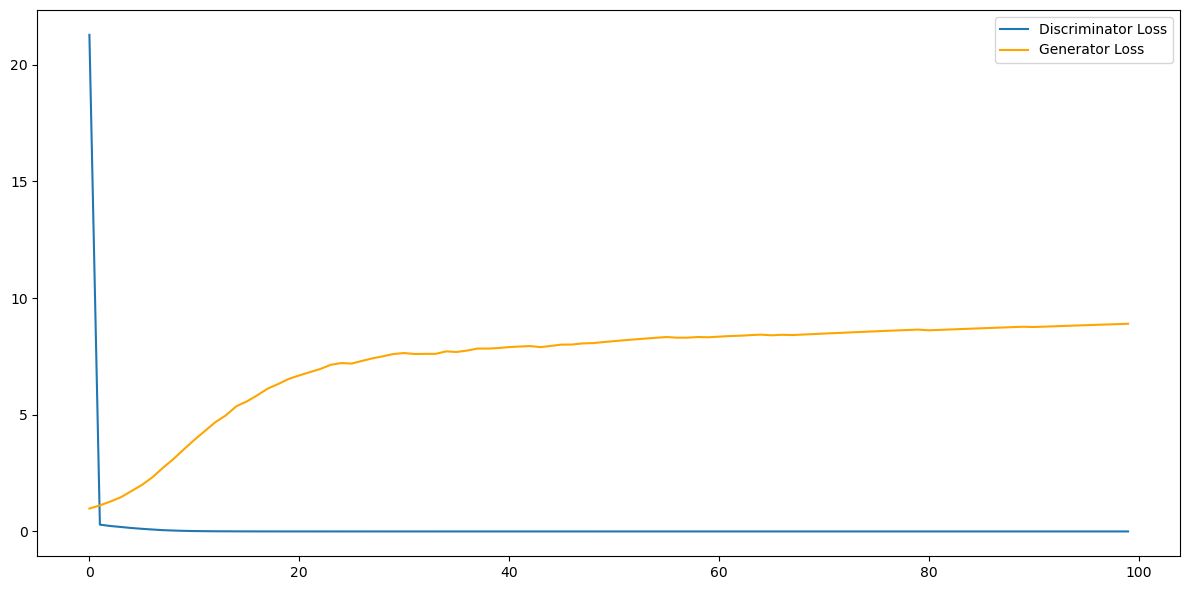

🎉 Training complete paaji!


In [10]:
# ----------- Plot Losses ----------- 
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 6))

# Plot Discriminator Loss
plt.plot(d_losses, label='Discriminator Loss')

# Plot Generator Loss
plt.plot(g_losses, label='Generator Loss', color='orange')
plt.legend()

plt.tight_layout()
plt.show()

print("🎉 Training complete paaji!")